### Expectation-Maximization (EM) algorithm using MAP estimation 

Example notebook using the EM algorithm with MAP estimation to perform parameter recovery for a simple Rescorla-Wagner reinforcement learning model (i.e., simulations, model fitting)

In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
import pickle, datetime
from scipy.stats import norm, beta, gamma
from tqdm import tqdm

In [69]:
import sys
sys.path.append('../')
from pyEM.fitting import EMfit
from pyEM.math import norm2alpha, norm2beta, alpha2norm, beta2norm, compGauss_ms, calc_BICint
from pyEM import plotting
import rw_models
import joblib

# Data formating

In [70]:
# load dataframe
baseline_slot = pd.read_csv('../data/glm_slot_baseline_n235.csv')

sub_c = baseline_slot[['participant', 'block_type', 'choice', 'reward', 'opt_act', 'optimal']]
sub_c

,participant,block_type,choice,reward,opt_act,optimal
0,54847f1cfdf99b07b28f22f9,numberbar_neg,1,0,1,0
1,54847f1cfdf99b07b28f22f9,numberbar_neg,1,0,1,0
2,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,1,1
3,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,1,1
4,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,1,1
...,...,...,...,...,...,...
25085,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,1,1
25086,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,1,1
25087,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,1,1
25088,63d1c1b521f75a8a9f14160f,numberbar_mixed,1,0,1,0


In [71]:
# check for flat behavior by participant per block
flat_check = sub_c.groupby(['participant', 'block_type']).choice.mean().reset_index()
# find flat response by participant
flat_check['flat_l'] = flat_check.choice.apply(lambda x: 1 if x == 1 else 0)
flat_check['flat_r'] = flat_check.choice.apply(lambda x: 1 if x == 0 else 0)
flat_check['flat'] = flat_check.flat_l + flat_check.flat_r

# returen subject ID with flat == 1
flat_sub = flat_check[flat_check.flat == 1].participant.unique()
print(f'Flat subjects: {len(flat_sub)}')

# remove flat subjects
sub_c = sub_c[~sub_c.participant.isin(flat_sub)]
sub_c

Flat subjects: 6


,participant,block_type,choice,reward,opt_act,optimal
0,54847f1cfdf99b07b28f22f9,numberbar_neg,1,0,1,0
1,54847f1cfdf99b07b28f22f9,numberbar_neg,1,0,1,0
2,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,1,1
3,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,1,1
4,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,1,1
...,...,...,...,...,...,...
25085,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,1,1
25086,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,1,1
25087,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,1,1
25088,63d1c1b521f75a8a9f14160f,numberbar_mixed,1,0,1,0


In [72]:
# Recode reward back to outcome (-1, 0, 1)
def recode_outcome(row):
    if row['block_type'] == 'numberbar_neg' and row['reward'] == 1:
        return 0  # Negative block and reward 1 = $0
    elif row['block_type'] == 'numberbar_neg' and row['reward'] == 0:
        return -1   # Negative block and reward 0 = -$10
    elif row['block_type'] == 'numberbar_pos' and row['reward'] == 1:
        return 1   # Positive block and reward 1 = $10
    elif row['block_type'] == 'numberbar_pos' and row['reward'] == 0:
        return 0   # Positive block and reward 0 = $0
    elif row['block_type'] == 'numberbar_mixed' and row['reward'] == 1:
        return 1   # Mixed block and reward 1 = $10
    elif row['block_type'] == 'numberbar_mixed' and row['reward'] == 0:
        return -1   # Mixed block and reward 0 = -$10
    else:
        return None  # Handle any unexpected cases (optional)

# Apply the function to the DataFrame to create a new 'outcome' column
sub_c['outcome'] = sub_c.apply(recode_outcome, axis=1)
# select subjects with exactly 105 trials
sub_c = sub_c.groupby('participant').filter(lambda x: len(x) == 105) #complete trials 
sub_c = sub_c.groupby('participant').filter(lambda x: x['outcome'].isnull().sum() == 0)
sub_c

c:\Users\fuq01\Anaconda3\envs\emfit\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,participant,block_type,choice,reward,opt_act,optimal,outcome
0,54847f1cfdf99b07b28f22f9,numberbar_neg,1,0,1,0,-1
1,54847f1cfdf99b07b28f22f9,numberbar_neg,1,0,1,0,-1
2,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,1,1,0
3,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,1,1,0
4,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,1,1,0
...,...,...,...,...,...,...,...
25085,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,1,1,1
25086,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,1,1,1
25087,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,1,1,1
25088,63d1c1b521f75a8a9f14160f,numberbar_mixed,1,0,1,0,-1


# Simulation 

no need to run for fitting right now

In [73]:
mod = 'basic'

if mod == 'basic':
    modelID = 'sim_basic'
    param_names = ['lr', 'beta'] # basic
    objfunc_dict = {modelID: rw_models.fit_slot_basic}
elif mod == 'valence':
    modelID = 'sim_valence'
    param_names = ['alpha_pos', 'alpha_neg', 'beta'] # valence
    objfunc_dict = {modelID: rw_models.fit_slot_valence}
elif mod == 'outcome':
    modelID = 'sim_outcome'
    param_names = ['alpha_rew', 'alpha_pun', 'beta'] # outcome
    objfunc_dict = {modelID: rw_models.fit_slot_outcome}
elif mod == 'context':
    modelID = 'sim_context'
    param_names = ['alpha_opt', 'alpha_pes', 'alpha_mix', 'beta'] # context
    objfunc_dict = {modelID: rw_models.fit_slot_context}

simul_dict   = {modelID: rw_models.simulate}

In [74]:
# modelID = 'sim_basic'
# # param_names = ['lr', 'beta'] # basic
# param_names = ['alpha_pos', 'alpha_neg', 'beta'] # valence
# # param_names = ['alpha_opt', 'alpha_pes', 'alpha_mix', 'beta'] # context
# # param_names = ['alpha_rew', 'alpha_pun', 'beta'] # outcome
# objfunc_dict = {modelID: rw_models.fit_slot_basic}
# simul_dict   = {modelID: rw_models.simulate}

In [75]:
nsubjects = 219 
betamin, betamax   = .75,  10
alphamin, alphamax = .05, .95

params = np.ones((nsubjects, len(param_names)))
for simS in tqdm(range(nsubjects)):
    for idx, param in enumerate(param_names):
        if 'alpha' or 'lr' in param:
            # For alpha, we will sample from a beta distribution and then transform
            params[simS, idx] = beta.rvs(1.1, 1.1)
            while params[simS, idx] > alphamax or params[simS, idx] < alphamin:
                params[simS, idx] = beta.rvs(1.1, 1.1)
        if 'beta' in param:
            # For beta, we will sample from a normal distribution and then transform
            # Note: can also use a gamma distribution (`gamma.rvs(1, scale=5)`)
            params[simS, -1] = norm.rvs(0, scale=1)
            while params[simS, -1] > betamax or params[simS, -1] < betamin:
                params[simS, -1] = norm2beta(norm.rvs(0, scale=1))

100%|██████████| 219/219 [00:00<00:00, 5651.24it/s]


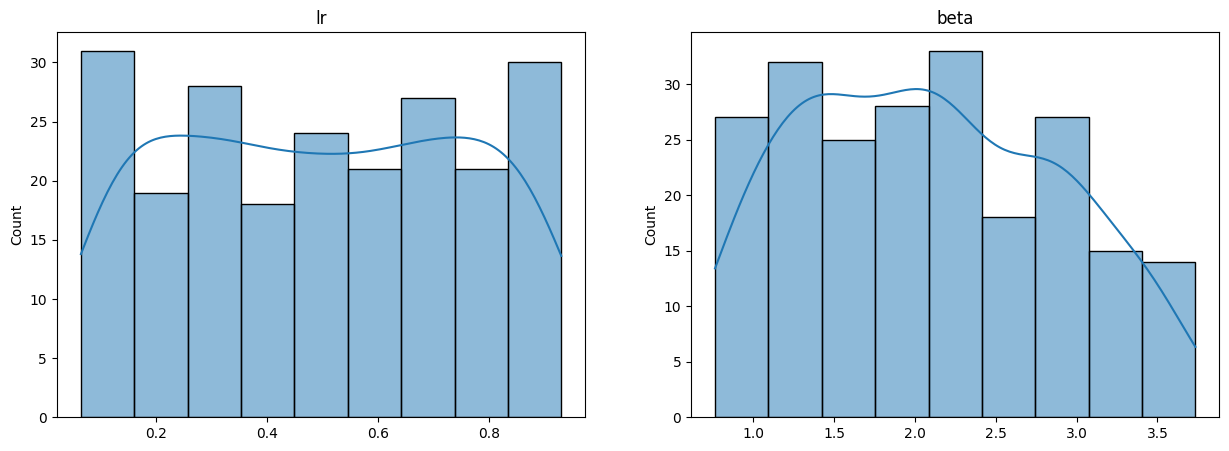

In [76]:
# visualize the simulated parameters distribution
fig, ax = plt.subplots(1, len(param_names), figsize=(15, 5))
for idx, param in enumerate(param_names):
    sns.histplot(params[:, idx], ax=ax[idx], kde=True)
    ax[idx].set_title(param)

In [77]:
# plot 2 x 2
# plt.figure(figsize=(7, 6))
# plt.subplot(221)
# plt.hist(params[:,0]);
# plt.title(f'alpha - min: {min(params[:,0]):.2f}, max: {max(params[:,0]):.2f}');

# plt.subplot(222)
# plt.hist(beta2norm(params[:,0]));
# plt.title(f'alpha - norm');

# plt.subplot(223)
# plt.hist(params[:,1]);
# plt.title(f'beta - min: {min(params[:,1]):.2f}, max: {max(params[:,1]):.2f}');

# plt.subplot(224)
# plt.hist(alpha2norm(params[:,1]));
# plt.title(f'beta - norm');

# plt.tight_layout()

In [78]:
# Assume you have a DataFrame `sub_c` with columns: 'participant', 'block_type', 'trial', 'reward', 'opt_act'
n_subjects = 219
n_blocks = 3
n_trials = 35

# Initialize empty arrays to store the data (in NumPy format)
reward_for_sim = np.zeros((n_subjects, n_blocks, n_trials))
opt_act_for_sim = np.zeros((n_subjects, n_blocks, n_trials))
blocks_for_sim = np.zeros((n_subjects, n_blocks, n_trials), dtype=object)

# Get the unique block types (assume there are 3 types of blocks)
unique_blocks = sorted(sub_c['block_type'].unique())
grouped = sub_c.groupby(['participant', 'block_type'])

for i, subject in enumerate(sub_c['participant'].unique()):
    for j, block in enumerate(unique_blocks):
        # Extract the data for this subject and block
        group = grouped.get_group((subject, block))

        rewards = group['reward'].values
        opt_act = group['opt_act'].values
        blocks  = group['block_type'].values
        
        if len(rewards) == n_trials:  # Ensure correct number of trials
            reward_for_sim[i, j, :] = rewards
            opt_act_for_sim[i, j, :] = opt_act
            blocks_for_sim[i, j, :] = blocks

In [79]:
# simulation code chunk!
ntrials, nblocks = 35, 3
print(f'ntrials: {ntrials}, nblocks: {nblocks}')

simulfunc = simul_dict[modelID]
subj_dict = simulfunc(params, nblocks=nblocks, ntrials=ntrials, opt_act=opt_act_for_sim, blocks=blocks_for_sim, policy=mod)

ntrials: 35, nblocks: 3


  2%|▏         | 4/219 [00:00<00:06, 35.64it/s]

[0.5 0.5] [0. 0.] 1
[0.86051202 0.13948798] [ 0.      -0.66092] 1
[0.91957022 0.08042978] [ 0.         -0.88502476] 1
[0.93374702 0.06625298] [ 0.         -0.96101419] 1
[0.93800268 0.06199732] [ 0.         -0.98678069] 1
[0.28938279 0.71061721] [0.         0.32632241] 1
[0.81978999 0.18021001] [ 0.        -0.5502706] 1
[0.21317904 0.78682096] [0.         0.47433425] 0
[0.0420709 0.9579291] [-0.66092     0.47433425] 0
[0.02314883 0.97685117] [-0.88502476  0.47433425] 0
[0.42250586 0.57749414] [0.36082581 0.47433425] 0
[0.70067493 0.29932507] [0.78326882 0.47433425] 0
[0.08361364 0.91638636] [-0.39532921  0.47433425] 0
[0.02947028 0.97052972] [-0.79496823  0.47433425] 0
[0.44314035 0.55685965] [0.39136218 0.47433425] 0
[0.05951997 0.94048003] [-0.52821692  0.47433425] 0
[0.02612192 0.97387808] [-0.84002779  0.47433425] 0
[0.0196547 0.9803453] [-0.94575662  0.47433425] 0
[0.01784042 0.98215958] [-0.98160716  0.47433425] 0
[0.01726338 0.98273662] [-0.99376335  0.47433425] 0
[0.01707191 0.

  5%|▌         | 12/219 [00:00<00:05, 36.86it/s]

[0.65175017 0.34824983] [0.29309468 0.        ] 1
[0.65175017 0.34824983] [0.29309468 0.        ] 0
[0.70420978 0.29579022] [0.40565054 0.        ] 1
[0.70420978 0.29579022] [0.40565054 0.        ] 1
[0.70420978 0.29579022] [0.40565054 0.        ] 1
[0.70420978 0.29579022] [0.40565054 0.        ] 1
[0.70420978 0.29579022] [0.40565054 0.        ] 0
[0.67465413 0.32534587] [0.34106149 0.        ] 1
[0.67465413 0.32534587] [0.34106149 0.        ] 1
[0.59600218 0.40399782] [0.34106149 0.15922338] 0
[0.56775844 0.43224156] [0.28675652 0.15922338] 1
[0.49661174 0.50338826] [0.28675652 0.29309468] 0
[0.47223183 0.52776817] [0.24109818 0.29309468] 0
[0.53673398 0.46326602] [0.36193309 0.29309468] 0
[0.50599257 0.49400743] [0.30430488 0.29309468] 1
[0.53090138 0.46909862] [0.30430488 0.24642715] 1
[0.46684607 0.53315393] [0.30430488 0.36641357] 1
[0.41373849 0.58626151] [0.30430488 0.46729535] 0
[0.38885196 0.61114804] [0.25585243 0.46729535] 0
[0.36836154 0.63163846] [0.21511474 0.46729535] 0


 10%|▉         | 21/219 [00:00<00:05, 37.46it/s]

[0.57152665 0.42847335] [-0.3251295  -0.48125448] 0
[0.60096757 0.39903243] [-0.25932881 -0.48125448] 1
[0.6463921 0.3536079] [-0.25932881 -0.58623976] 1
[0.68086101 0.31913899] [-0.25932881 -0.66997781] 1
[0.70702408 0.29297592] [-0.25932881 -0.73676869] 1
[0.64699054 0.35300946] [-0.25932881 -0.58765922] 1
[0.59541155 0.40458845] [-0.25932881 -0.46872698] 1
[0.64216656 0.35783344] [-0.25932881 -0.57624761] 1
[0.59135924 0.40864076] [-0.25932881 -0.45962489] 1
[0.63908244 0.36091756] [-0.25932881 -0.56898763] 0
[0.57316817 0.42683183] [-0.40922808 -0.56898763] 0
[0.51853459 0.48146541] [-0.52879028 -0.56898763] 1
[0.46547769 0.53452231] [-0.52879028 -0.4538342 ] 1
[0.51640656 0.48359344] [-0.52879028 -0.56436888] 0
[0.47244847 0.52755153] [-0.62415512 -0.56436888] 1
[0.42041386 0.57958614] [-0.62415512 -0.45015021] 0
[0.38664677 0.61335323] [-0.70021974 -0.45015021] 0
[0.5 0.5] [0. 0.] 0
[0.59228948 0.40771052] [0.20238301 0.        ] 0
[0.57391943 0.42608057] [0.16142413 0.        ] 

 14%|█▎        | 30/219 [00:00<00:04, 39.65it/s]

[0.64428041 0.35571959] [0.22301668 0.        ] 1
[0.64428041 0.35571959] [0.22301668 0.        ] 1
[0.64428041 0.35571959] [0.22301668 0.        ] 1
[0.23590901 0.76409099] [0.22301668 0.66426601] 0
[0.54969119 0.45030881] [0.73914029 0.66426601] 1
[0.40261807 0.59738193] [0.73914029 0.88728269] 1
[0.76409099 0.23590901] [0.73914029 0.29789096] 1
[0.84583214 0.15416786] [0.73914029 0.10001212] 1
[0.5274702 0.4725298] [0.73914029 0.69784348] 1
[0.3954181 0.6045819] [0.73914029 0.89855579] 1
[0.76226909 0.23773091] [0.73914029 0.30167572] 1
[0.48242288 0.51757712] [0.73914029 0.7655488 ] 0
[0.20132266 0.79867734] [0.24815452 0.7655488 ] 0
[0.13978329 0.86021671] [0.08331391 0.7655488 ] 0
[0.45133934 0.54866066] [0.69223732 0.7655488 ] 0
[0.58643398 0.41356602] [0.89667361 0.7655488 ] 0
[0.2249271 0.7750729] [0.30104381 0.7655488 ] 0
[0.14556757 0.85443243] [0.10107064 0.7655488 ] 1
[0.10114236 0.89885764] [0.10107064 0.92128676] 0
[0.35567611 0.64432389] [0.69819886 0.92128676] 0
[0.138

 18%|█▊        | 40/219 [00:01<00:04, 39.18it/s]

[0.61902821 0.38097179] [0.59260042 0.33804734] 0
[0.54082033 0.45917967] [0.42386169 0.33804734] 0
[0.61691791 0.38308209] [0.58791295 0.33804734] 0
[0.53923217 0.46076783] [0.42050895 0.33804734] 0
[0.61583658 0.38416342] [0.58551488 0.33804734] 1
[0.52808929 0.47191071] [0.58551488 0.52653362] 1
[0.46390912 0.53609088] [0.58551488 0.66134979] 0
[0.38638164 0.61361836] [0.41879371 0.66134979] 1
[0.4741638 0.5258362] [0.41879371 0.47303517] 1
[0.40381913 0.59618087] [0.41879371 0.62308463] 0
[0.35046849 0.64953151] [0.2995452  0.62308463] 0
[0.31439908 0.68560092] [0.21425185 0.62308463] 1
[0.27204013 0.72795987] [0.21425185 0.73040859] 1
[0.24403498 0.75596502] [0.21425185 0.80717281] 0
[0.22321615 0.77678385] [0.15324517 0.80717281] 0
[0.31276234 0.68723766] [0.39435254 0.80717281] 1
[0.41363839 0.58636161] [0.39435254 0.57733613] 1
[0.35928943 0.64071057] [0.39435254 0.69768664] 1
[0.450263 0.549737] [0.39435254 0.49902536] 0
[0.53226918 0.46773082] [0.56680632 0.49902536] 0
[0.590

 22%|██▏       | 48/219 [00:01<00:04, 39.42it/s]

[0.5733542 0.4266458] [0.29218074 0.16559741] 0
[0.61665147 0.38334853] [0.369193   0.16559741] 0
[0.65375943 0.34624057] [0.43782617 0.16559741] 1
[0.66321912 0.33678088] [0.43782617 0.14758006] 1
[0.61328211 0.38671789] [0.43782617 0.24032519] 1
[0.56663785 0.43336215] [0.43782617 0.32297945] 1
[0.52402165 0.47597835] [0.43782617 0.39664075] 0
[0.49623458 0.50376542] [0.39018973 0.39664075] 1
[0.45801522 0.54198478] [0.39018973 0.46228754] 1
[0.42435212 0.57564788] [0.39018973 0.52079181] 1
[0.39492236 0.60507764] [0.39018973 0.5729307 ] 0
[0.37149959 0.62850041] [0.34773625 0.5729307 ] 0
[0.35111866 0.64888134] [0.30990179 0.5729307 ] 1
[0.32681727 0.67318273] [0.30990179 0.61939676] 1
[0.30591193 0.69408807] [0.30990179 0.66080721] 0
[0.2894561 0.7105439] [0.27618381 0.66080721] 0
[0.32868173 0.67131827] [0.35493657 0.66080721] 1
[0.36672648 0.63327352] [0.35493657 0.58890996] 1
[0.40210949 0.59789051] [0.35493657 0.52483529] 0
[0.44205763 0.55794237] [0.42512087 0.52483529] 0
[0.4

 26%|██▌       | 57/219 [00:01<00:04, 38.70it/s]

[0.99617045 0.00382955] [ 0.99995608 -0.99999979] 1
[0.59556815 0.40443185] [0.99995608 0.86076809] 0
[0.00826856 0.99173144] [-0.86077113  0.86076809] 0
[0.00578211 0.99421789] [-0.99030745  0.86076809] 0
[0.00563974 0.99436026] [-0.99932524  0.86076809] 0
[0.00562996 0.99437004] [-0.99995303  0.86076809] 0
[0.00562928 0.99437072] [-0.99999673  0.86076809] 0
[0.00562923 0.99437077] [-0.99999977  0.86076809] 0
[0.5 0.5] [0.86076809 0.86076809] 0
[0.00805052 0.99194948] [-0.87046084  0.86076809] 0
[0.00577134 0.99422866] [-0.99098201  0.86076809] 0
[0.5 0.5] [0. 0.] 0
[0.06997528 0.93002472] [-0.93038404  0.        ] 0
[0.45509598 0.54490402] [-0.06476958  0.        ] 0
[0.06916371 0.93083629] [-0.93489303  0.        ] 1
[0.49686556 0.50313444] [-0.93489303 -0.93038404] 1
[0.5417931 0.4582069] [-0.93489303 -0.99515362] 0
[0.9299679 0.0700321] [-0.06508348 -0.99515362] 1
[0.50291624 0.49708376] [-0.06508348 -0.06927858] 1
[0.91830268 0.08169732] [-0.06508348 -0.93520693] 1
[0.93002868 0.

 30%|███       | 66/219 [00:01<00:03, 38.67it/s]

[0.13558546 0.86441454] [0.33736695 0.99960173] 0
[0.3481855 0.6518145] [0.77544591 0.99960173] 1
[0.77233911 0.22766089] [0.77544591 0.33874655] 1
[0.86389445 0.13610555] [0.77544591 0.11479494] 1
[0.55255162 0.44744838] [0.77544591 0.70002037] 1
[0.81840119 0.18159881] [0.77544591 0.23722396] 0
[0.51786718 0.48213282] [0.26278428 0.23722396] 0
[0.80765628 0.19234372] [0.75017122 0.23722396] 1
[0.86686937 0.13313063] [0.75017122 0.08039082] 1
[0.88311103 0.11688897] [0.75017122 0.02724296] 1
[0.88821213 0.11178787] [0.75017122 0.00923214] 1
[0.55980067 0.44019933] [0.75017122 0.66424709] 1
[0.81286939 0.18713061] [0.75017122 0.22510106] 1
[0.86819002 0.13180998] [0.75017122 0.07628259] 0
[0.5 0.5] [0. 0.] 1
[0.64571708 0.35428292] [ 0.         -0.27986907] 0
[0.5 0.5] [-0.27986907 -0.27986907] 0
[0.68314469 0.31685531] [ 0.0783267  -0.27986907] 1
[0.5 0.5] [0.0783267 0.0783267] 0
[0.63488902 0.36511098] [0.33627455 0.0783267 ] 1
[0.76861929 0.23138071] [ 0.33627455 -0.22346359] 1
[0.6

 32%|███▏      | 70/219 [00:01<00:04, 34.55it/s]

[0.36637237 0.63362763] [0.27249458 0.44886646] 0
[0.33865826 0.66134174] [0.23338707 0.44886646] 0
[0.31576256 0.68423744] [0.19989214 0.44886646] 0
[0.2968342 0.7031658] [0.17120428 0.44886646] 0
[0.28115584 0.71884416] [0.14663362 0.44886646] 0
[0.36393246 0.63606754] [0.26910591 0.44886646] 0
[0.44212778 0.55787222] [0.37400139 0.44886646] 0
[0.51162689 0.48837311] [0.46384261 0.44886646] 1
[0.45037419 0.54962581] [0.46384261 0.5279633 ] 1
[0.50904589 0.49095411] [0.46384261 0.45219178] 0
[0.56836575 0.43163425] [0.54079013 0.45219178] 1
[0.61698176 0.38301824] [0.54079013 0.38729472] 0
[0.55865191 0.44134809] [0.46317774 0.38729472] 1
[0.60068841 0.39931159] [0.46317774 0.33171148] 0
[0.5 0.5] [0. 0.] 0
[0.34387893 0.65612107] [-0.83699939  0.        ] 0
[0.32052435 0.67947565] [-0.9734308  0.       ] 0
[0.31679754 0.68320246] [-0.9956692  0.       ] 0
[0.31619228 0.68380772] [-0.99929408  0.        ] 1
[0.46872324 0.53127676] [-0.99929408 -0.83699939] 1
[0.49500939 0.50499061] [-

 36%|███▌      | 78/219 [00:02<00:05, 27.76it/s]

[0.48860068 0.51139932] [0.20973605 0.22640139] 1
[0.42082521 0.57917479] [0.20973605 0.32644845] 0
[0.32136187 0.67863813] [0.05328471 0.32644845] 1
[0.43092419 0.56907581] [0.05328471 0.15490307] 0
[0.34279896 0.65720104] [-0.08293327  0.15490307] 1
[0.27889868 0.72110132] [-0.08293327  0.26419678] 0
[0.36200464 0.63799536] [0.05711907 0.26419678] 0
[0.44201648 0.55798352] [0.17905888 0.26419678] 0
[0.51438456 0.48561544] [0.28522859 0.26419678] 0
[0.40196203 0.59803797] [0.11901405 0.26419678] 1
[0.51252509 0.48747491] [0.11901405 0.10070221] 0
[0.58949969 0.41050031] [0.23294917 0.10070221] 1
[0.51090581 0.48909419] [0.23294917 0.21700555] 0
[0.57812827 0.42187173] [0.33214943 0.21700555] 1
[0.50949576 0.49050424] [0.33214943 0.31826775] 1
[0.62352358 0.37647642] [0.33214943 0.14778035] 1
[0.5 0.5] [0. 0.] 0
[0.41243542 0.58756458] [-0.12932684  0.        ] 0
[0.34028074 0.65971926] [-0.24192824  0.        ] 0
[0.28285778 0.71714222] [-0.33996727  0.        ] 0
[0.23795576 0.762044

 37%|███▋      | 82/219 [00:02<00:04, 29.35it/s]

[0.5 0.5] [0. 0.] 0
[0.95089193 0.04910807] [0.92282238 0.        ] 1
[0.5 0.5] [0.92282238 0.92282238] 1
[0.44307133 0.55692867] [0.92282238 0.99404362] 1
[0.43872027 0.56127973] [0.92282238 0.9995403 ] 1
[0.43838485 0.56161515] [0.92282238 0.99996452] 0
[0.00261006 0.99738994] [-0.85160115  0.99996452] 0
[0.00168294 0.99831706] [-0.98854693  0.99996452] 0
[0.00162687 0.99837313] [-0.99911608  0.99996452] 0
[0.00162262 0.99837738] [-0.99993178  0.99996452] 0
[0.00162229 0.99837771] [-0.99999474  0.99996452] 0
[0.00162227 0.99837773] [-0.99999959  0.99996452] 0
[0.00162227 0.99837773] [-0.99999997  0.99996452] 0
[0.00162227 0.99837773] [-1.          0.99996452] 0
[0.37858624 0.62141376] [0.84564476 0.99996452] 1
[0.99564079 0.00435921] [ 0.84564476 -0.8456475 ] 1
[0.49043773 0.50956227] [0.84564476 0.85755732] 1
[0.99579132 0.00420868] [ 0.84564476 -0.85663815] 1
[0.99724402 0.00275598] [ 0.84564476 -0.98893567] 1
[0.49931447 0.50068553] [0.84564476 0.84649868] 0
[0.61174915 0.38825085

 41%|████      | 90/219 [00:02<00:04, 29.46it/s]

[0.56952893 0.43047107] [ 0.         -0.15970727] 0
[0.56952893 0.43047107] [ 0.         -0.15970727] 1
[0.53814154 0.46185846] [ 0.         -0.08721253] 1
[0.70663468 0.29336532] [ 0.         -0.50154739] 1
[0.61776063 0.38223937] [ 0.         -0.27388369] 0
[0.42175671 0.57824329] [-0.4539226  -0.27388369] 0
[0.51139399 0.48860601] [-0.24787687 -0.27388369] 0
[0.56040347 0.43959653] [-0.13535996 -0.27388369] 1
[0.69434509 0.30565491] [-0.13535996 -0.6034843 ] 1
[0.75694231 0.24305769] [-0.13535996 -0.78347174] 1
[0.78722226 0.21277774] [-0.13535996 -0.88175881] 0
[0.80470391 0.19529609] [-0.07391701 -0.88175881] 1
[0.67137544 0.32862456] [-0.07391701 -0.48150856] 1
[0.75527277 0.24472723] [-0.07391701 -0.71686354] 0
[0.76597913 0.23402087] [-0.04036441 -0.71686354] 1
[0.5 0.5] [0. 0.] 1
[0.5 0.5] [0. 0.] 1
[0.5 0.5] [0. 0.] 1
[0.5 0.5] [0. 0.] 1
[0.5 0.5] [0. 0.] 0
[0.68903679 0.31096321] [0.4539226 0.       ] 1
[0.68903679 0.31096321] [0.4539226 0.       ] 1
[0.68903679 0.31096321] 

 45%|████▍     | 98/219 [00:02<00:03, 32.03it/s]

[0.55345891 0.44654109] [0.3189891  0.19756576] 0
[0.53889336 0.46110664] [0.28574627 0.19756576] 1
[0.50201372 0.49798628] [0.28574627 0.28118989] 1
[0.46894693 0.53105307] [0.28574627 0.35609929] 1
[0.43954743 0.56045257] [0.28574627 0.42320216] 0
[0.42662309 0.57337691] [0.25596777 0.42320216] 0
[0.41512958 0.58487042] [0.22929259 0.42320216] 0
[0.40491129 0.59508871] [0.2053973  0.42320216] 0
[0.39582706 0.60417294] [0.18399222 0.42320216] 0
[0.38774993 0.61225007] [0.16481783 0.42320216] 0
[0.4248454 0.5751546] [0.25185472 0.42320216] 0
[0.41354901 0.58645099] [0.22560817 0.42320216] 0
[0.44852158 0.55147842] [0.30630991 0.42320216] 0
[0.48029858 0.51970142] [0.37860148 0.42320216] 0
[0.50890768 0.49109232] [0.44335932 0.42320216] 1
[0.52836988 0.47163012] [0.44335932 0.37909897] 0
[0.55382862 0.44617138] [0.50136855 0.37909897] 0
[0.57640082 0.42359918] [0.55333246 0.37909897] 1
[0.59335625 0.40664375] [0.55333246 0.3395919 ] 1
[0.60835932 0.39164068] [0.55333246 0.30420199] 1
[0

 48%|████▊     | 106/219 [00:03<00:03, 31.36it/s]

[0.13752036 0.86247964] [-0.93443478 -0.0423051 ] 0
[0.12824514 0.87175486] [-0.97356183 -0.0423051 ] 0
[0.1246586 0.8753414] [-0.98933922 -0.0423051 ] 1
[0.11909871 0.88090129] [-0.98933922 -0.01705888] 0
[0.11773188 0.88226812] [-0.9957012  -0.01705888] 0
[0.31191146 0.68808854] [-0.40150122 -0.01705888] 1
[0.60253008 0.39746992] [-0.40150122 -0.60364409] 1
[0.71152658 0.28847342] [-0.40150122 -0.84017557] 1
[0.75009163 0.24990837] [-0.40150122 -0.93555325] 1
[0.76463344 0.23536656] [-0.40150122 -0.97401284] 1
[0.77032886 0.22967114] [-0.40150122 -0.98952108] 1
[0.7725979 0.2274021] [-0.40150122 -0.99577453] 1
[0.77350837 0.22649163] [-0.40150122 -0.99829615] 1
[0.50053837 0.49946163] [-0.40150122 -0.40254759] 1
[0.67610417 0.32389583] [-0.40150122 -0.75908649] 0
[0.50021709 0.49978291] [-0.75866456 -0.75908649] 0
[0.5 0.5] [0. 0.] 0
[0.5 0.5] [0. 0.] 1
[0.22650229 0.77349771] [0.         0.59676536] 0
[0.22650229 0.77349771] [0.         0.59676536] 0
[0.22650229 0.77349771] [0.     

 50%|█████     | 110/219 [00:03<00:03, 32.81it/s]

[0.5 0.5] [0. 0.] 1
[0.1019962 0.8980038] [0.         0.76509832] 0
[0.01273634 0.98726366] [-0.76509832  0.76509832] 0
[0.00767986 0.99232014] [-0.9448212   0.76509832] 0
[0.00681716 0.99318284] [-0.98703841  0.76509832] 0
[0.00662889 0.99337111] [-0.9969553   0.76509832] 0
[0.00658542 0.99341458] [-0.99928479  0.76509832] 0
[0.00657525 0.99342475] [-0.999832    0.76509832] 0
[0.00657287 0.99342713] [-0.99996054  0.76509832] 0
[0.00657231 0.99342769] [-0.99999073  0.76509832] 0
[0.00657218 0.99342782] [-0.99999782  0.76509832] 0
[0.00657215 0.99342785] [-0.99999949  0.76509832] 0
[0.00657214 0.99342786] [-0.99999988  0.76509832] 0
[0.00657214 0.99342786] [-0.99999997  0.76509832] 0
[0.33897951 0.66102049] [0.53019664 0.76509832] 0
[0.58760887 0.41239113] [0.8896424  0.76509832] 1
[0.98513251 0.01486749] [ 0.8896424  -0.58537543] 1
[0.99391308 0.00608692] [ 0.8896424  -0.90260399] 1
[0.99506947 0.00493053] [ 0.8896424  -0.97712151] 1
[0.99530772 0.00469228] [ 0.8896424 -0.9946258] 1
[0

 54%|█████▍    | 119/219 [00:03<00:02, 34.17it/s]

[0.38623805 0.61376195] [-0.18427396 -0.02836019] 1
[0.75978262 0.24021738] [-0.18427396 -0.5719056 ] 1
[0.86563255 0.13436745] [-0.18427396 -0.81138605] 1
[0.89810235 0.10189765] [-0.18427396 -0.91689866] 0
[0.69439904 0.30560096] [-0.64059958 -0.91689866] 1
[0.72289387 0.27710613] [-0.64059958 -0.96338641] 1
[0.73491517 0.26508483] [-0.64059958 -0.98386843] 1
[0.35086087 0.64913913] [-0.64059958 -0.43348221] 1
[0.5 0.5] [0. 0.] 1
[0.5 0.5] [0. 0.] 1
[0.5 0.5] [0. 0.] 0
[0.84047539 0.15952461] [0.55941039 0.        ] 1
[0.84047539 0.15952461] [0.55941039 0.        ] 0
[0.67527873 0.32472127] [0.24647041 0.        ] 1
[0.67527873 0.32472127] [0.24647041 0.        ] 1
[0.67527873 0.32472127] [0.24647041 0.        ] 1
[0.28300362 0.71699638] [0.24647041 0.55941039] 0
[0.57995322 0.42004678] [0.66800269 0.55941039] 0
[0.31270892 0.68729108] [0.29431504 0.55941039] 1
[0.53547181 0.46452819] [0.29431504 0.24647041] 1
[0.63453061 0.36546939] [0.29431504 0.1085923 ] 1
[0.67527873 0.32472127] 

 58%|█████▊    | 127/219 [00:03<00:02, 32.60it/s]

[0.19943015 0.80056985] [0.02222339 0.70934244] 0
[0.1951847 0.8048153] [0.00897064 0.70934244] 1
[0.14588217 0.85411783] [0.00897064 0.8826738 ] 1
[0.33124676 0.66875324] [0.00897064 0.35629819] 0
[0.32885411 0.67114589] [0.00362107 0.35629819] 0
[0.32789079 0.67210921] [0.00146167 0.35629819] 1
[0.18329209 0.81670791] [0.00146167 0.74016473] 1
[0.14092544 0.85907456] [0.00146167 0.89511546] 0
[0.35362433 0.64637567] [0.59693219 0.89511546] 1
[0.61694004 0.38305996] [0.59693219 0.36132036] 0
[0.7236776 0.2763224] [0.83729852 0.36132036] 0
[0.76115734 0.23884266] [0.93432428 0.36132036] 1
[0.83130086 0.16869914] [0.93432428 0.14584979] 1
[0.85455776 0.14544224] [0.93432428 0.05887341] 1
[0.86316389 0.13683611] [0.93432428 0.02376471] 1
[0.86651458 0.13348542] [0.93432428 0.00959281] 1
[0.86784733 0.13215267] [0.93432428 0.00387221] 1
[0.8683821 0.1316179] [0.93432428 0.00156305] 1
[0.5 0.5] [0. 0.] 0
[0.4608966 0.5391034] [-0.14808038  0.        ] 1
[0.5 0.5] [-0.14808038 -0.14808038] 

 60%|█████▉    | 131/219 [00:03<00:02, 33.34it/s]

[0.5 0.5] [0. 0.] 1
[0.73448601 0.26551399] [ 0.         -0.43062504] 1
[0.83157688 0.16842312] [ 0.         -0.67581215] 1
[0.47295138 0.52704862] [0.         0.04583452] 0
[0.24493636 0.75506364] [-0.43062504  0.04583452] 0
[0.58172586 0.41827414] [0.18543792 0.04583452] 0
[0.76109313 0.23890687] [0.53620875 0.04583452] 1
[0.54681629 0.45318371] [0.53620875 0.45672207] 0
[0.65919849 0.34080151] [0.73592887 0.45672207] 1
[0.89491359 0.10508641] [ 0.73592887 -0.17057893] 1
[0.95193227 0.04806773] [ 0.73592887 -0.52774841] 0
[0.77198776 0.22801224] [-0.01160556 -0.52774841] 1
[0.84554609 0.15445391] [-0.01160556 -0.73111177] 1
[0.87800601 0.12199399] [-0.01160556 -0.84690177] 1
[0.52359566 0.47640434] [-0.01160556 -0.05157963] 0
[0.28674577 0.71325423] [-0.43723296 -0.05157963] 0
[0.63440179 0.36559821] [ 0.18167554 -0.05157963] 1
[0.37312391 0.62687609] [0.18167554 0.40125689] 1
[0.71237468 0.28762532] [ 0.18167554 -0.20215941] 1
[0.42158847 0.57841153] [0.18167554 0.31552053] 0
[0.626

 63%|██████▎   | 139/219 [00:04<00:02, 31.64it/s]

[0.37645039 0.62354961] [0.37446696 0.57692667] 1
[0.4149908 0.5850092] [0.37446696 0.51222567] 0
[0.38982506 0.61017494] [0.33247135 0.51222567] 1
[0.3579214 0.6420786] [0.33247135 0.56692844] 0
[0.33685648 0.66314352] [0.29518546 0.56692844] 1
[0.31036941 0.68963059] [0.29518546 0.61549642] 0
[0.29298979 0.70701021] [0.26208109 0.61549642] 1
[0.27123034 0.72876966] [0.26208109 0.65861761] 0
[0.5 0.5] [0. 0.] 0
[0.25271454 0.74728546] [-0.31565904  0.        ] 0
[0.13869874 0.86130126] [-0.53167745  0.        ] 0
[0.45871527 0.54128473] [-0.04818962  0.        ] 0
[0.72530233 0.27469767] [0.28268091 0.        ] 1
[0.47171293 0.52828707] [0.28268091 0.31565904] 0
[0.1818394 0.8181606] [-0.12220891  0.31565904] 0
[0.07902823 0.92097177] [-0.3992916   0.31565904] 0
[0.2811972 0.7188028] [0.04240744 0.31565904] 0
[0.11217693 0.88782307] [-0.28663789  0.31565904] 0
[0.33766002 0.66233998] [0.11950099 0.31565904] 0
[0.1315312 0.8684688] [-0.23387962  0.31565904] 0
[0.06191343 0.93808657] [-

 68%|██████▊   | 148/219 [00:04<00:02, 34.70it/s]

[0.0436126 0.9563874] [-0.95389932 -0.04594182] 1
[0.20641619 0.79358381] [-0.95389932 -0.55791915] 0
[0.19297434 0.80702566] [-0.97863838 -0.55791915] 0
[0.18697558 0.81302442] [-0.99010169 -0.55791915] 0
[0.18424503 0.81575497] [-0.99541343 -0.55791915] 0
[0.58146202 0.41853798] [-0.46124358 -0.55791915] 1
[0.75686606 0.24313394] [-0.46124358 -0.7951535 ] 1
[0.81897492 0.18102508] [-0.46124358 -0.90508051] 0
[0.62859394 0.37140606] [-0.75035706 -0.90508051] 1
[0.66805855 0.33194145] [-0.75035706 -0.95601727] 1
[0.26012664 0.73987336] [-0.75035706 -0.44298862] 0
[0.58032024 0.41967976] [-0.34769209 -0.44298862] 1
[0.7925938 0.2074062] [-0.34769209 -0.74189828] 0
[0.53747269 0.46252731] [-0.69774083 -0.74189828] 0
[0.80589381 0.19410619] [-0.32331137 -0.74189828] 1
[0.5 0.5] [0. 0.] 1
[0.13883547 0.86116453] [0.         0.53663115] 0
[0.5 0.5] [0.53663115 0.53663115] 0
[0.27302084 0.72697916] [0.24865816 0.53663115] 0
[0.19260838 0.80739162] [0.11522045 0.53663115] 0
[0.16199933 0.8380

 69%|██████▉   | 152/219 [00:04<00:01, 35.27it/s]

[0.5 0.5] [0. 0.] 1
[0.46013309 0.53986691] [0.         0.07833217] 0
[0.42076988 0.57923012] [-0.07833217  0.07833217] 1
[0.38534961 0.61465039] [-0.07833217  0.15052842] 1
[0.35373673 0.64626327] [-0.07833217  0.21706937] 0
[0.32083374 0.67916626] [-0.15052842  0.21706937] 0
[0.29199917 0.70800083] [-0.21706937  0.21706937] 0
[0.26682097 0.73317903] [-0.27839803  0.21706937] 0
[0.24487619 0.75512381] [-0.33492268  0.21706937] 0
[0.28642739 0.71357261] [-0.23035529  0.21706937] 0
[0.26196243 0.73803757] [-0.29064323  0.21706937] 0
[0.24064369 0.75935631] [-0.34620869  0.21706937] 0
[0.28210979 0.71789021] [-0.24075723  0.21706937] 1
[0.25747421 0.74252579] [-0.24075723  0.27839803] 0
[0.29716043 0.70283957] [-0.14356602  0.27839803] 0
[0.33668398 0.66331602] [-0.05398801  0.27839803] 1
[0.38371487 0.61628513] [-0.05398801  0.17825833] 1
[0.42910193 0.57089807] [-0.05398801  0.0859628 ] 0
[0.39252867 0.60747133] [-0.12809119  0.0859628 ] 1
[0.43458926 0.56541074] [-0.12809119  0.000896

 73%|███████▎  | 160/219 [00:04<00:01, 35.08it/s]

[0.4718045 0.5281955] [-0.03596996  0.10197088] 1
[0.44530256 0.55469744] [-0.03596996  0.23241645] 1
[0.42288844 0.57711156] [-0.03596996  0.34391381] 0
[0.45319735 0.54680265] [0.11451258 0.34391381] 0
[0.47939061 0.52060939] [0.24313638 0.34391381] 1
[0.51931393 0.48068607] [0.24313638 0.14870009] 1
[0.49402098 0.50597902] [0.24313638 0.27235789] 0
[0.51651065 0.48348935] [0.35307659 0.27235789] 0
[0.53568414 0.46431586] [0.44704715 0.27235789] 0
[0.5519915 0.4480085] [0.52736776 0.27235789] 1
[0.53051472 0.46948528] [0.52736776 0.37805345] 0
[0.54448263 0.45551737] [0.5960212  0.37805345] 1
[0.58473444 0.41526556] [0.5960212  0.17788068] 1
[0.61828572 0.38171428] [0.5960212  0.00678453] 1
[0.64610811 0.35389189] [ 0.5960212 -0.1394586] 0
[0.60162096 0.39837904] [ 0.36418695 -0.1394586 ] 1
[0.62586871 0.37413129] [ 0.36418695 -0.2644588 ] 1
[0.64610978 0.35389022] [ 0.36418695 -0.37130176] 0
[0.66319719 0.33680281] [ 0.45654364 -0.37130176] 1
[0.5 0.5] [0. 0.] 0
[0.5 0.5] [0. 0.] 0


 77%|███████▋  | 168/219 [00:04<00:01, 36.07it/s]

[0.40510049 0.59489951] [0.7465303  0.91315275] 1
[0.60583805 0.39416195] [0.7465303 0.5601375] 1
[0.71691973 0.28308027] [0.7465303  0.34359423] 0
[0.76046138 0.23953862] [0.84451902 0.34359423] 1
[0.81176767 0.18823233] [0.84451902 0.21076431] 1
[0.83881549 0.16118451] [0.84451902 0.12928504] 1
[0.85379773 0.14620227] [0.84451902 0.0793048 ] 1
[0.86240452 0.13759548] [0.84451902 0.0486464 ] 1
[0.86747051 0.13252949] [0.84451902 0.02984021] 0
[0.88261119 0.11738881] [0.90462633 0.02984021] 1
[0.88533962 0.11466038] [0.90462633 0.0183043 ] 1
[0.76292444 0.23707556] [0.90462633 0.39781754] 0
[0.77795854 0.22204146] [0.94149679 0.39781754] 1
[0.67193327 0.32806673] [0.94149679 0.63061495] 1
[0.78230636 0.21769364] [0.94149679 0.38682584] 1
[0.67535168 0.32464832] [0.94149679 0.62387252] 0
[0.4733037 0.5266963] [0.57752403 0.62387252] 0
[0.56703534 0.43296466] [0.7408488  0.62387252] 0
[0.62264921 0.37735079] [0.84103393 0.62387252] 0
[0.43806875 0.56193125] [0.51589905 0.62387252] 1
[0.3

 80%|████████  | 176/219 [00:05<00:01, 33.28it/s]

[0.38470444 0.61529556] [-0.11596417  0.14991313] 0
[0.34581669 0.65418331] [-0.21099242  0.14991313] 1
[0.31026423 0.68973577] [-0.21099242  0.24129208] 1
[0.28030691 0.71969309] [-0.21099242  0.32284838] 0
[0.25110113 0.74889887] [-0.29580574  0.32284838] 0
[0.5 0.5] [0. 0.] 1
[0.5 0.5] [0. 0.] 0
[0.45267473 0.54732527] [-0.10749367  0.        ] 1
[0.45267473 0.54732527] [-0.10749367  0.        ] 0
[0.41112198 0.58887802] [-0.20343245  0.        ] 1
[0.41112198 0.58887802] [-0.20343245  0.        ] 0
[0.37505922 0.62494078] [-0.28905842  0.        ] 1
[0.37505922 0.62494078] [-0.28905842  0.        ] 0
[0.343991 0.656009] [-0.36548014  0.        ] 0
[0.31733745 0.68266255] [-0.433687  0.      ] 0
[0.29451398 0.70548602] [-0.49456207  0.        ] 1
[0.335438 0.664562] [-0.49456207 -0.10749367] 0
[0.31439354 0.68560646] [-0.54889344 -0.10749367] 0
[0.29623121 0.70376879] [-0.59738454 -0.10749367] 1
[0.33273299 0.66726701] [-0.59738454 -0.20343245] 0
[0.35837482 0.64162518] [-0.53316949

 82%|████████▏ | 180/219 [00:05<00:01, 32.70it/s]

[0.09007433 0.90992567] [-0.44061671  0.70876137] 0
[0.20992361 0.79007639] [0.05007186 0.70876137] 1
[0.17872798 0.82127202] [0.05007186 0.80796018] 0
[0.29443386 0.70556614] [0.37362695 0.80796018] 0
[0.13998966 0.86001034] [-0.09424423  0.80796018] 0
[0.25627428 0.74372572] [0.27846638 0.80796018] 1
[0.54331132 0.45668868] [0.27846638 0.19215073] 0
[0.66109802 0.33890198] [0.524228   0.19215073] 0
[0.72992982 0.27007018] [0.68628074 0.19215073] 1
[0.85952129 0.14047871] [ 0.68628074 -0.21390782] 0
[0.883534 0.116466] [ 0.79313668 -0.21390782] 1
[0.92858056 0.07141944] [ 0.79313668 -0.48165874] 1
[0.94884269 0.05115731] [ 0.79313668 -0.65821099] 1
[0.5 0.5] [0. 0.] 1
[0.5 0.5] [0. 0.] 0
[0.33506594 0.66493406] [-0.34061007  0.        ] 0
[0.24282004 0.75717996] [-0.56520493  0.        ] 1
[0.24282004 0.75717996] [-0.56520493  0.        ] 1
[0.24282004 0.75717996] [-0.56520493  0.        ] 1
[0.24282004 0.75717996] [-0.56520493  0.        ] 0
[0.19227861 0.80772139] [-0.71330051  0.  

 86%|████████▌ | 188/219 [00:05<00:00, 32.97it/s]

[0.4387384 0.5612616] [0.24985239 0.51214962] 0
[0.52858108 0.47141892] [0.6340402  0.51214962] 0
[0.45253095 0.54746905] [0.30931675 0.51214962] 0
[0.41600509 0.58399491] [0.1509003  0.51214962] 0
[0.39849016 0.60150984] [0.07361677 0.51214962] 0
[0.39003595 0.60996405] [0.03591397 0.51214962] 1
[0.33586865 0.66413135] [0.03591397 0.762002  ] 0
[0.44567833 0.55432167] [0.52967026 0.762002  ] 0
[0.38394029 0.61605971] [0.25839984 0.762002  ] 0
[0.3550036 0.6449964] [0.12606046 0.762002  ] 0
[0.34124813 0.65875187] [0.06149864 0.762002  ] 0
[0.44857543 0.55142457] [0.54215175 0.762002  ] 0
[0.50343569 0.49656431] [0.77663856 0.762002  ] 1
[0.59391565 0.40608435] [0.77663856 0.37174297] 1
[0.63620749 0.36379251] [0.77663856 0.18135495] 0
[0.54623484 0.45376516] [0.37888342 0.18135495] 0
[0.61872813 0.38127187] [0.69698804 0.18135495] 1
[0.63907778 0.36092222] [0.69698804 0.08847408] 1
[0.64883206 0.35116794] [0.69698804 0.04316212] 0
[0.56923729 0.43076271] [0.34002588 0.04316212] 1
[0.5

 90%|████████▉ | 197/219 [00:05<00:00, 30.90it/s]

[0.8049243 0.1950757] [0.66539106 0.2054453 ] 1
[0.83647917 0.16352083] [0.66539106 0.13570817] 0
[0.71834081 0.28165919] [0.4395282  0.13570817] 1
[0.5 0.5] [0. 0.] 1
[0.3068547 0.6931453] [0.         0.89264186] 0
[0.16386727 0.83613273] [-0.89264186  0.89264186] 1
[0.47814333 0.52185667] [-0.89264186 -0.79680949] 0
[0.45637003 0.54362997] [-0.98847423 -0.79680949] 0
[0.80928544 0.19071456] [ 0.7865211  -0.79680949] 1
[0.49530416 0.50469584] [0.7865211  0.80709787] 1
[0.45611989 0.54388011] [0.7865211  0.97929039] 0
[0.49949585 0.50050415] [0.9770813  0.97929039] 1
[0.4952771 0.5047229] [0.9770813  0.99777665] 0
[0.1638376 0.8361624] [-0.78774422  0.99777665] 0
[0.14149757 0.85850243] [-0.97721261  0.99777665] 0
[0.1392569 0.8607431] [-0.99755359  0.99777665] 0
[0.4517163 0.5482837] [0.78554636 0.99777665] 0
[0.49525322 0.50474678] [0.97697666 0.99777665] 0
[0.49994331 0.50005669] [0.99752826 0.99777665] 0
[0.50044685 0.49955315] [0.99973464 0.99777665] 0
[0.5005009 0.4994991] [0.999

 92%|█████████▏| 201/219 [00:05<00:00, 32.35it/s]

[0.5 0.5] [0. 0.] 1
[0.57692146 0.42307854] [ 0.         -0.26039904] 1
[0.63170407 0.36829593] [ 0.         -0.45299042] 0
[0.70050055 0.29949945] [ 0.26039904 -0.45299042] 1
[0.73484337 0.26515663] [ 0.26039904 -0.59543119] 1
[0.75856222 0.24143778] [ 0.26039904 -0.70078052] 1
[0.77514867 0.22485133] [ 0.26039904 -0.77869698] 1
[0.66506662 0.33493338] [ 0.26039904 -0.315526  ] 0
[0.71409197 0.28590803] [ 0.45299042 -0.315526  ] 1
[0.62418116 0.37581884] [0.45299042 0.02703571] 1
[0.69548028 0.30451972] [ 0.45299042 -0.2404034 ] 1
[0.74296838 0.25703162] [ 0.45299042 -0.43820163] 1
[0.64917131 0.35082869] [ 0.45299042 -0.06369531] 0
[0.5410961 0.4589039] [ 0.07463311 -0.06369531] 1
[0.45880678 0.54119322] [0.07463311 0.21328993] 1
[0.39911739 0.60088261] [0.07463311 0.41814847] 0
[0.32247089 0.67752911] [-0.20520032  0.41814847] 1
[0.28436739 0.71563261] [-0.20520032  0.56966205] 0
[0.23696243 0.76303757] [-0.41216539  0.56966205] 0
[0.20558905 0.79441095] [-0.56523696  0.56966205] 0


 95%|█████████▌| 209/219 [00:06<00:00, 30.63it/s]

[0.46717503 0.53282497] [-0.09835864  0.        ] 0
[0.43781245 0.56218755] [-0.18704286  0.        ] 0
[0.41170056 0.58829944] [-0.26700422  0.        ] 0
[0.38857154 0.61142846] [-0.33910069  0.        ] 0
[0.36813602 0.63186398] [-0.40410585  0.        ] 1
[0.33811391 0.66188609] [-0.40410585  0.09835864] 1
[0.31211144 0.68788856] [-0.40410585  0.18704286] 0
[0.29554152 0.70445848] [-0.46271719  0.18704286] 0
[0.28104847 0.71895153] [-0.5155636   0.18704286] 0
[0.26835889 0.73164111] [-0.5632121   0.18704286] 1
[0.24789703 0.75210297] [-0.5632121   0.26700422] 1
[0.2303669 0.7696331] [-0.5632121   0.33910069] 0
[0.22034218 0.77965782] [-0.60617397  0.33910069] 0
[0.21157509 0.78842491] [-0.64491016  0.33910069] 0
[0.24989551 0.75010449] [-0.48311903  0.33910069] 1
[0.23396244 0.76603756] [-0.48311903  0.40410585] 0
[0.22200248 0.77799752] [-0.53395874  0.40410585] 0
[0.25877676 0.74122324] [-0.38308064  0.40410585] 0
[0.29515521 0.70484479] [-0.24704271  0.40410585] 0
[0.33037182 0.

 97%|█████████▋| 213/219 [00:06<00:00, 30.53it/s]

[0.54402949 0.45597051] [0.9870555  0.83261812] 1
[0.50030642 0.49969358] [0.9870555  0.98598348] 1
[0.88911631 0.11088369] [ 0.9870555 -0.8336942] 1
[0.54010473 0.45989527] [0.9870555  0.84644687] 0
[0.12776354 0.87223646] [-0.83360443  0.84644687] 0
[0.10956465 0.89043535] [-0.98606607  0.84644687] 0
[0.49635291 0.50364709] [0.83368728 0.84644687] 1
[0.87211089 0.12788911] [ 0.83368728 -0.84537896] 1
[0.49663258 0.50336742] [0.83368728 0.84546839] 1
[0.87212134 0.12787866] [ 0.83368728 -0.8454609 ] 0
[0.49971801 0.50028199] [-0.84644745 -0.8454609 ] 1
[0.12626031 0.87373969] [-0.84644745  0.84546153] 0
[0.49997639 0.50002361] [0.84537891 0.84546153] 0
[0.12638386 0.87361614] [-0.84546839  0.84546153] 0
[0.10956375 0.89043625] [-0.98705956  0.84546153] 0
[0.49661076 0.50338924] [0.83360409 0.84546153] 0
[0.54010356 0.45989644] [0.98606604 0.84546153] 1
[0.49971618 0.50028382] [0.98606604 0.98705898] 0
[0.50336544 0.49663456] [0.99883317 0.98705898] 0
[0.50367102 0.49632898] [0.9999022

100%|██████████| 219/219 [00:06<00:00, 33.58it/s]

[0.90632754 0.09367246] [0.95918332 0.04995834] 1
[0.60810009 0.39189991] [0.95918332 0.78318174] 1
[0.87524363 0.12475637] [0.95918332 0.17873753] 1
[0.90825222 0.09174778] [0.95918332 0.04079143] 1
[0.914594 0.085406] [0.95918332 0.00930941] 1
[0.61360468 0.38639532] [0.95918332 0.77390485] 1
[0.5067285 0.4932715] [0.95918332 0.94840062] 1
[0.48188518 0.51811482] [0.95918332 0.988224  ] 1
[0.47622355 0.52377645] [0.95918332 0.99731249] 1
[0.47493226 0.52506774] [0.95918332 0.99938666] 1
[0.47463761 0.52536239] [0.95918332 0.99986002] 1
[0.86112941 0.13887059] [0.95918332 0.22818779] 1
[0.90587759 0.09412241] [0.95918332 0.05207696] 1
[0.60781243 0.39218757] [0.95918332 0.78366525] 1
[0.5 0.5] [0. 0.] 1
[0.6231788 0.3768212] [ 0.         -0.37724278] 0
[0.5 0.5] [-0.37724278 -0.37724278] 0
[0.66659827 0.33340173] [ 0.14231212 -0.37724278] 0
[0.75478733 0.24521267] [ 0.46586868 -0.37724278] 0
[0.59553293 0.40446707] [-0.0871197  -0.37724278] 0
[0.71784066 0.28215934] [ 0.32298836 -0.37

In [80]:
subj_dict['ev'].shape

(219, 3, 36, 2)

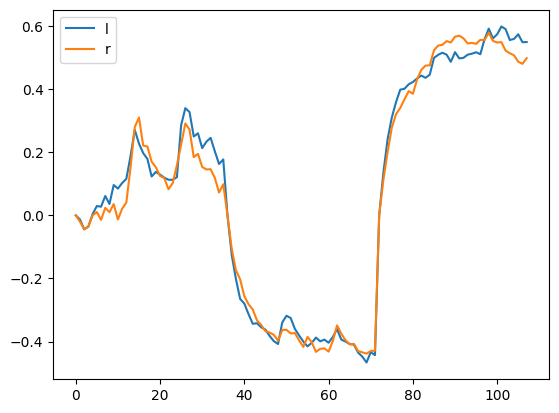

In [81]:
plt.plot(subj_dict['ev'][:,:,:,0].mean(axis=0).ravel(),label='l')

plt.plot(subj_dict['ev'][:,:,:,1].mean(axis=0).ravel(),label='r')
plt.legend()
plt.show()


In [59]:
print(subj_dict['params'][0,:])

[0.38564704 3.19921891]


In [121]:
print(subj_dict.keys())

dict_keys(['params', 'ev', 'ch_prob', 'choices', 'choices_L', 'outcomes', 'opt_act', 'blocks', 'pe', 'choice_nll'])


In [122]:
# Specify the keys you want to select
selected_keys = ['choices', 'choices_L', 'outcomes', 'opt_act', 'blocks', 'pe', 'choice_nll', 'params']
sub_dict = {key: subj_dict[key] for key in selected_keys if key in subj_dict}

In [123]:
# Iterate over the dictionary and print the shape of each array
for key, array in sub_dict.items():
    print(f"Key: {key}, Shape: {array.shape}")

Key: choices, Shape: (219, 3, 35)
Key: choices_L, Shape: (219, 3, 35)
Key: outcomes, Shape: (219, 3, 35)
Key: opt_act, Shape: (219, 3, 35)
Key: blocks, Shape: (219, 3, 35)
Key: pe, Shape: (219, 3, 35)
Key: choice_nll, Shape: (219, 3, 35)
Key: params, Shape: (219, 2)


In [124]:
# Assume your dictionary of NumPy arrays (all arrays have shape (219, 3, 35) except params which has shape (219, 2))
data_dict = sub_dict

# Initialize lists to hold the DataFrame content
subject_list = []
block_list = []
trial_list = []
data_dict_flattened = {key: [] for key in data_dict.keys() if key != 'params'}  # Exclude params for now

# Step 1: Flatten the arrays and prepare subject, block, and trial information
for subject in range(data_dict['outcomes'].shape[0]):  # 219 subjects
    for block in range(data_dict['outcomes'].shape[1]):  # 3 blocks
        for trial in range(data_dict['outcomes'].shape[2]):  # 35 trials
            # Append subject, block, and trial information
            subject_list.append(subject)
            block_list.append(block)
            trial_list.append(trial)
            
            # Append the values from each array (except 'params')
            for key in data_dict.keys():
                if key != 'params':
                    data_dict_flattened[key].append(data_dict[key][subject, block, trial])

# Step 2: Create the DataFrame for all keys except 'params'
sim_df = pd.DataFrame({
    'subject': subject_list,
    'block': block_list,
    'trial': trial_list,
})

# Add the flattened values from the dictionary as columns in the DataFrame
for key in data_dict_flattened.keys():
    sim_df[key] = data_dict_flattened[key]

# Step 3: Add param1 and param2 directly to sim_df
params_df = pd.DataFrame(data_dict['params'], columns=param_names)
params_df['subject'] = params_df.index  # Add the subject column

# Step 4: Merge param1 and param2 with sim_df on the subject column
sim_df = pd.merge(sim_df, params_df, on='subject', how='left')

# View the final DataFrame
sim_df.head(13)


,subject,block,trial,choices,choices_L,outcomes,opt_act,blocks,pe,choice_nll,lr,beta
0,0,0,0,0,0.0,-1.0,1.0,numberbar_mixed,-1.500000,0.500000,0.261599,2.255025
1,0,0,1,1,1.0,-1.0,1.0,numberbar_mixed,-1.500000,0.707830,0.261599,2.255025
2,0,0,2,1,1.0,1.0,1.0,numberbar_mixed,0.892399,0.500000,0.261599,2.255025
3,0,0,3,0,0.0,1.0,1.0,numberbar_mixed,0.892399,0.371348,0.261599,2.255025
4,0,0,4,1,1.0,-1.0,1.0,numberbar_mixed,-1.341052,0.500000,0.261599,2.255025
5,0,0,5,1,1.0,1.0,1.0,numberbar_mixed,1.009766,0.311932,0.261599,2.255025
6,0,0,6,1,1.0,-1.0,1.0,numberbar_mixed,-1.254388,0.451297,0.261599,2.255025
7,0,0,7,0,0.0,1.0,1.0,numberbar_mixed,0.658948,0.718171,0.261599,2.255025
8,0,0,8,0,0.0,1.0,1.0,numberbar_mixed,0.486568,0.789868,0.261599,2.255025
9,0,0,9,0,0.0,1.0,1.0,numberbar_mixed,0.359282,0.833573,0.261599,2.255025


In [125]:
# same model simulation 
sim_df['model'] = modelID
sim_df.to_csv(f'../data/simulated_{mod}.csv', index=False)

In [126]:
# check for subject 0 
# simcheck = sim_df[sim_df.subject == 0]
# # save this as example csv
# simcheck.to_csv('simcheck_L.csv', index=False)

c:\Users\fuq01\AppData\Local\anaconda3\envs\emfit\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='trial', ylabel='outcomes'>

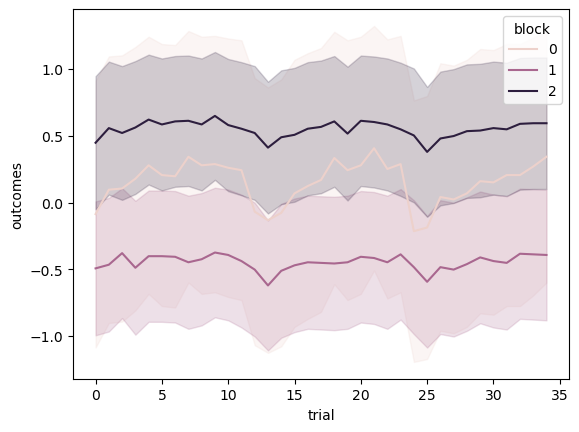

In [127]:
sns.lineplot(data=sim_df, x='trial', y='outcomes', hue='block', ci='sd')
# sns.lineplot(data=sim_df, x='trial', y='choices', hue='block', ci='sd')

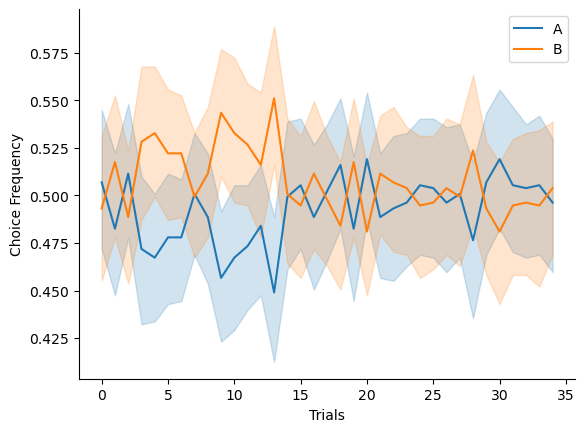

In [128]:
plotting.plot_choices(subj_dict['choices_L']) 

# Fit subject behavior data

Text(0.5, 0, 'Trial index')

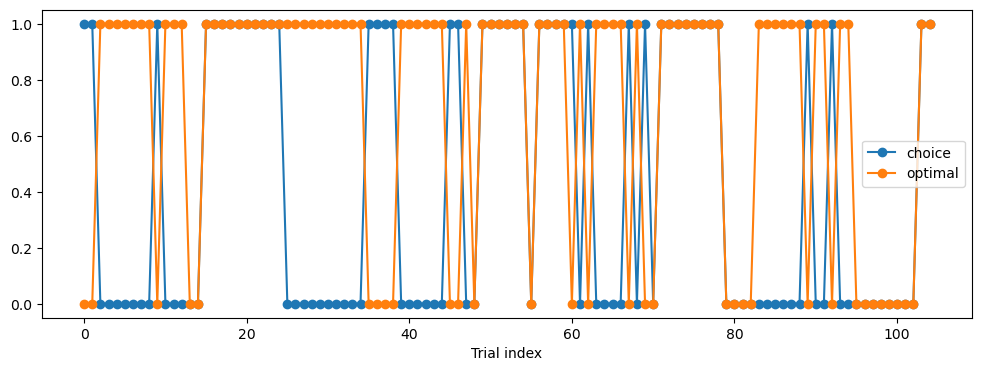

In [7]:
# check subject behavior 
id = '5f4d5f9f835880a2aca8b996'
check_sub = sub_c[sub_c.participant == id]
check_sub.reset_index(drop=True, inplace=True)

# plot choices by trial index 
plt.figure(figsize=(12, 4))
plt.plot(check_sub.choice, 'o-')
plt.plot(check_sub.optimal, 'o-')
plt.legend(['choice', 'optimal'])
plt.xlabel('Trial index')

# sns.catplot(x='block_type', y='optimal', data=check_sub, kind='bar', errorbar=('se', 1))

In [8]:
sub_c['participant'].nunique() #from 225 to 219 after checking for random behaivor, flat behaivor, and complete trials

219

In [9]:
all_data = []

# Step 2: Group by subject
grouped = sub_c.groupby('participant')

# Step 3: Iterate through each group (subject)
for subject, group in grouped:
    # Step 4: Sort the group by block (if needed)
    group_sorted = group.sort_values('block_type')
    
    # Step 5: Extract choices_L and rewards
    choices_L = group_sorted['choice'].values
    outcomes = group_sorted['outcome'].values
    blocks = group_sorted['block_type'].values
    
    # Step 6: Reshape choices_L and rewards into 3x35 arrays
    choices = choices_L.reshape(3, 35)
    outcomes = outcomes.reshape(3, 35)
    blocks = blocks.reshape(3, 35)
    
    # Step 7: Append the subject data as a list of [choices_L_array, rewards_array]
    all_data.append([choices, outcomes, blocks])

In [10]:
len(all_data)

219

In [68]:
# create a list of lists with choices and rewards for each subject (simulation code)
# all_data = []
# for idx, (choices, rewards) in enumerate(zip(subj_dict['choices'], subj_dict['rewards'])):
#     all_data += [[choices, rewards]]

In [137]:
modelID = 'RW_basic'
param_names = ['alpha', 'beta'] # slot version
objfunc_dict = {modelID: rw_models.fit_slot_basic}
nsubjects = len(all_data) 

In [70]:
modelID = 'RW_outcome'
param_names = ['alpha_rew', 'alpha_pun', 'beta'] # slot version
objfunc_dict = {modelID: rw_models.fit_slot_outcome}
nsubjects = len(all_data) 

In [11]:
modelID = 'RW_valence'
param_names = ['alpha_pos', 'alpha_neg', 'beta'] # slot version
objfunc_dict = {modelID: rw_models.fit_slot_valence}
nsubjects = len(all_data) 

In [101]:
modelID = 'RW_context'
param_names = ['alpha_opt', 'alpha_pes', 'alpha_mix', 'beta'] # slot version
objfunc_dict = {modelID: rw_models.fit_slot_context}
nsubjects = len(all_data) 

In [99]:
# modelID = 'RW_context_r'
# param_names = ['alpha_opt', 'alpha_pes', 'beta'] # slot version
# objfunc_dict = {modelID: rw_models.fit_slot_context_r}
# nsubjects = len(all_data) 

In [12]:
m, inv_h, posterior, NPL, NLPrior, NLL = EMfit(all_data, objfunc_dict['RW_valence'], param_names) 
# est 11m for RW_basic, 40m for RW_outcome, 71m for RW_valence, 74m for RW_context

20900.990 (000), 15832.054 (001), 15624.736 (002), 15530.040 (003), 15475.359 (004), 15440.118 (005), 15416.811 (006), 15403.237 (007), 15391.304 (008), 15382.129 (009), 15375.389 (010), 15368.652 (011), 15364.549 (012), 15358.679 (013), 15353.542 (014), 15351.555 (015), 15348.958 (016), 15348.220 (017), 15346.041 (018), 15344.875 (019), 15344.253 (020), 15344.141 (029), 15342.123 (030), 15340.571 (031), 15340.180 (032), 15338.940 (033), 15338.230 (035), 15337.762 (036), 15337.743 (041), 15337.650 (077), 15337.491 (078), 15337.407 (179), 15337.362 (180), 15337.106 (252), 15336.917 (400), 15336.789 (659), -MAXIMUM NUMBER OF ITERATIONS REACHED



In [13]:
nsubjects = m.shape[1]
print(nsubjects)

219


In [14]:
param_names

['alpha_pos', 'alpha_neg', 'beta']

In [15]:
## Now store all relevant outputs in modout dict and save it
save_fit = True

# define your own ntrials and nblocks base on task structure
nblocks = 3
ntrials = 35

# get covariance matrix
_, _, _, covmat_out = compGauss_ms(m,inv_h,2)
nparams = len(param_names)

# Fill in general information
modout = {}
modout[modelID] = {}
modout[modelID]['date'] = datetime.date.today().strftime('%Y%m%d')
# modout[modelID]['behavior'] = subj_dict  # copy behavior here

# Fill in fit information
# important for fitted parameters to convert back to parameter space
est_params = m.T.copy()
for subj_idx in range(nsubjects):
    for param_idx, param_name in enumerate(param_names):
        if 'beta' in param_name:
            est_params[subj_idx, param_idx] = norm2beta(m[param_idx, subj_idx])
        if 'alpha' in param_name: # check in param string contain alpha
            est_params[subj_idx, param_idx] = norm2alpha(m[param_idx, subj_idx])

In [16]:
# not sure what this chunk is doing 
modout[modelID]['fit'] = {}
modout[modelID]['fit']['norm_params'] = m
modout[modelID]['fit']['params'] = est_params
modout[modelID]['fit']['param_names'] = param_names
modout[modelID]['fit']['inverse_hess'] = inv_h
modout[modelID]['fit']['gauss.mu'] = posterior['mu']
modout[modelID]['fit']['gauss.sigma'] = posterior['sigma']
modout[modelID]['fit']['gauss.cov'] = covmat_out
try:
    modout[modelID]['fit']['gauss.corr'] = np.corrcoef(covmat_out)
except:
    print('covariance mat not square, symmetric, or positive semi-definite')
    modout[modelID]['fit']['gauss.corr'] = np.eye(nparams)
modout[modelID]['fit']['npl'] = NPL  # note: this is the negative joint posterior likelihood
modout[modelID]['fit']['NLPrior'] = NLPrior
modout[modelID]['fit']['nll'] = NPL - NLPrior

# should comment out for bic calculation: double check with Shawn why again. 
# modout[modelID]['fit']['aic'] = 2*nparams + 2*modout[modelID]['fit']['nll']
# modout[modelID]['fit']['bic'] = np.log(ntrials*nblocks)*nparams + 2*modout[modelID]['fit']['nll']
# modout[modelID]['fit']['lme'] = []

# Make sure you know if BIC is positive or negative! and replace lme with
# bic if covariance is negative.
# Error check that BICs are in a similar range

# Get subject specifics
goodHessian = np.zeros(nsubjects)
modout[modelID]['fit']['ev']          = np.zeros((nsubjects, nblocks, ntrials+1, 2))
modout[modelID]['fit']['ch_prob']     = np.zeros((nsubjects, nblocks, ntrials,   2))
modout[modelID]['fit']['choices']     = np.empty((nsubjects, nblocks, ntrials,), dtype='object')
modout[modelID]['fit']['choices_L']   = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['outcomes']    = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['pe']          = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['negll']       = np.zeros((nsubjects,))
modout[modelID]['fit']['bic']         = np.zeros((nsubjects,))

In [17]:
# from mfit_optimize_hierarchical.m from Sam Gershman
# Also reference Daw 2009 (Equation 17) for Laplace approximation
for subj_idx in range(nsubjects):
    try:
        det_inv_hessian = np.linalg.det(inv_h[:, :, subj_idx])
        hHere = np.linalg.slogdet(inv_h[:, :, subj_idx])[1]
        L = -NPL - 0.5 * np.log(1 / det_inv_hessian) + (nparams / 2) * np.log(2 * np.pi)
        goodHessian[subj_idx] = 1
    except:
        print('Hessian is not positive definite')
        try:
            hHere = np.linalg.slogdet(inv_h[:,:,subj_idx])[1]
            L = np.nan
            goodHessian[subj_idx] = 0
        except:
            print('could not calculate')
            goodHessian[subj_idx] = -1
            L = np.nan
    modout[modelID]['fit']['lme'] = L
    modout[modelID]['fit']['goodHessian'] = goodHessian

    # Get subjectwise model predictions# get info for current subject
    # choices = subj_dict['choices'][subj_idx,:,:]
    # rewards = subj_dict['rewards'][subj_idx,:,:]

    # note here to change from simualtion dataframe to your own data structure. 
    # 0-choices, 1-outomces, 2-blocks
    # change here for model! 
    model_fits = rw_models.fit_slot_basic(m[:,subj_idx], all_data[subj_idx][0], all_data[subj_idx][1], all_data[subj_idx][2], prior=None, output='all') # outputs subj_dict from your fit function

    # store model fits
    modout[modelID]['fit']['ev'][subj_idx,:,:,:] = model_fits['ev']
    modout[modelID]['fit']['ch_prob'][subj_idx,:,:,:] = model_fits['ch_prob']
    modout[modelID]['fit']['choices'][subj_idx,:,:] = model_fits['choices']
    # modout[modelID]['fit']['choices_L'][subj_idx,:,:] = model_fits['choices_L']
    modout[modelID]['fit']['outcomes'][subj_idx,:,:] = model_fits['outcomes'] # double check our variable names 
    modout[modelID]['fit']['pe'][subj_idx,:,:] = model_fits['pe']
    modout[modelID]['fit']['negll'][subj_idx] = model_fits['negll']
    modout[modelID]['fit']['bic'][subj_idx] = model_fits['BIC'] #fixed BIC problem!!!

# Save output
if save_fit:
    with open(f'EMfit_{modelID}.pkl', 'wb') as f:
        pickle.dump(modout, f)

In [18]:
np.max(est_params, axis=0), np.min(est_params, axis=0)

(array([0.80009095, 0.83178835, 2.60094989]),
 array([0.10562774, 0.01767391, 0.88192485]))

In [19]:
modout[modelID]['fit'].keys()

dict_keys(['norm_params', 'params', 'param_names', 'inverse_hess', 'gauss.mu', 'gauss.sigma', 'gauss.cov', 'gauss.corr', 'npl', 'NLPrior', 'nll', 'ev', 'ch_prob', 'choices', 'choices_L', 'outcomes', 'pe', 'negll', 'bic', 'lme', 'goodHessian'])

In [20]:
modout[modelID]['fit']['lme'].shape

(219, 800)

In [21]:
modout[modelID]['fit']['goodHessian'].shape

(219,)

In [22]:
#  fitted 3 parameters output for each subjects # 225 subjects fitted (need to regroup them with ID later)
# est_params are local variable (not sure if its saved in the pkl file)
param_df = pd.DataFrame(est_params, columns=modout[modelID]['fit']['param_names'])
bic_df = pd.DataFrame(modout[modelID]['fit']['bic'], columns=['bic'])
lme_df = pd.DataFrame(np.sum(modout[modelID]['fit']['lme'], axis=1), columns=['lme'])
hess_df = pd.DataFrame(modout[modelID]['fit']['goodHessian'], columns=['goodHessian'])

In [23]:
# get participant ID
param_df['participant'] = sub_c['participant'].unique()

psych_df = baseline_slot[['participant','depression', 'anhedonia', 'group']]
fit_df = pd.merge(psych_df, param_df, on='participant')
# plot_df = pd.concat([plot_df, bic_df], axis=1)

# Map the 'depression' and 'anhedonia' values to 'high' and 'low'
fit_df['depression_level'] = pd.Categorical(fit_df['depression'].map({1: 'high', 0: 'low'}), categories=['low', 'high'], ordered=True)
fit_df['anhedonia_level'] = pd.Categorical(fit_df['anhedonia'].map({1: 'high', 0: 'low'}), categories=['low', 'high'], ordered=True)

fit_df.drop_duplicates(subset='participant', inplace=True)
fit_df = fit_df.reset_index(drop=True)
fit_df = pd.concat([fit_df, bic_df], axis=1)
# fit_df = pd.concat([fit_df, lme_df], axis=1)
# fit_df = pd.concat([fit_df, hess_df], axis=1)
fit_df['model'] = modelID

fit_df

,participant,depression,anhedonia,group,alpha_pos,alpha_neg,beta,depression_level,anhedonia_level,bic,model
0,54847f1cfdf99b07b28f22f9,0,1,Anhedonia,0.796390,0.260466,2.600950,low,high,118.664073,RW_valence
1,54e32a60fdf99b3eae9de85b,1,1,Both,0.557108,0.831788,0.971667,high,high,412.853599,RW_valence
2,559002fefdf99b3f7aada38f,1,1,Both,0.472173,0.178773,1.037809,high,high,173.862807,RW_valence
3,5590a34cfdf99b729d4f69dc,1,0,Depression,0.576982,0.333570,2.251712,high,low,130.271989,RW_valence
4,5596a991fdf99b2d1e834690,0,0,Healthy,0.672697,0.454430,1.370001,low,low,194.198476,RW_valence
...,...,...,...,...,...,...,...,...,...,...,...
214,63ae31ff5c725a41082afc56,1,1,Both,0.695292,0.071895,1.184916,high,high,165.438876,RW_valence
215,63b6cee06aaa9fc9669b8cc2,0,0,Healthy,0.105628,0.531884,1.065308,low,low,235.624125,RW_valence
216,63c34086cb929e7c9b844a67,0,1,Anhedonia,0.496632,0.073622,1.001814,low,high,165.730819,RW_valence
217,63d15717bf9f5277f27bbe5e,1,1,Both,0.680137,0.178458,1.075429,high,high,186.973813,RW_valence


In [24]:
# save fitted params to csv
fit_df.to_csv(f'RW_fit_slot_{modelID}_Sep24.csv', index=False)

c:\Users\fuq01\AppData\Local\anaconda3\envs\emfit\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'RW basic model')

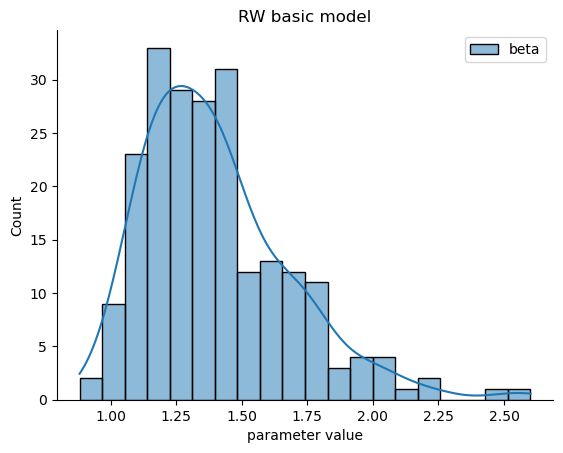

In [25]:
sns.histplot(data=fit_df, x='beta', kde=True, bins=20, palette='Set2', label='beta')
plt.legend()
sns.despine()
plt.xlabel('parameter value')
plt.title('RW basic model')

# fit subject by groups

In [87]:
# load dataframe
baseline_slot = pd.read_csv('../data/glm_slot_baseline_n235.csv')

sub_c = baseline_slot[['participant', 'block_type', 'choice', 'reward', 'group']]
sub_c

,participant,block_type,choice,reward,group
0,54847f1cfdf99b07b28f22f9,numberbar_neg,1,0,Anhedonia
1,54847f1cfdf99b07b28f22f9,numberbar_neg,1,0,Anhedonia
2,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,Anhedonia
3,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,Anhedonia
4,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,Anhedonia
...,...,...,...,...,...
25085,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,Anhedonia
25086,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,Anhedonia
25087,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,Anhedonia
25088,63d1c1b521f75a8a9f14160f,numberbar_mixed,1,0,Anhedonia


In [88]:
# check for flat behavior by participant per block
flat_check = sub_c.groupby(['participant', 'block_type']).choice.mean().reset_index()
# find flat response by participant
flat_check['flat_l'] = flat_check.choice.apply(lambda x: 1 if x == 1 else 0)
flat_check['flat_r'] = flat_check.choice.apply(lambda x: 1 if x == 0 else 0)
flat_check['flat'] = flat_check.flat_l + flat_check.flat_r

# returen subject ID with flat == 1
flat_sub = flat_check[flat_check.flat == 1].participant.unique()
print(f'Flat subjects: {len(flat_sub)}')

# remove flat subjects
sub_c = sub_c[~sub_c.participant.isin(flat_sub)]
sub_c

Flat subjects: 6


,participant,block_type,choice,reward,group
0,54847f1cfdf99b07b28f22f9,numberbar_neg,1,0,Anhedonia
1,54847f1cfdf99b07b28f22f9,numberbar_neg,1,0,Anhedonia
2,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,Anhedonia
3,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,Anhedonia
4,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,Anhedonia
...,...,...,...,...,...
25085,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,Anhedonia
25086,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,Anhedonia
25087,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,Anhedonia
25088,63d1c1b521f75a8a9f14160f,numberbar_mixed,1,0,Anhedonia


In [89]:
# Recode reward back to outcome (-1, 0, 1)
def recode_outcome(row):
    if row['block_type'] == 'numberbar_neg' and row['reward'] == 1:
        return 0  # Negative block and reward 1 = $0
    elif row['block_type'] == 'numberbar_neg' and row['reward'] == 0:
        return -1   # Negative block and reward 0 = -$10
    elif row['block_type'] == 'numberbar_pos' and row['reward'] == 1:
        return 1   # Positive block and reward 1 = $10
    elif row['block_type'] == 'numberbar_pos' and row['reward'] == 0:
        return 0   # Positive block and reward 0 = $0
    elif row['block_type'] == 'numberbar_mixed' and row['reward'] == 1:
        return 1   # Mixed block and reward 1 = $10
    elif row['block_type'] == 'numberbar_mixed' and row['reward'] == 0:
        return -1   # Mixed block and reward 0 = -$10
    else:
        return None  # Handle any unexpected cases (optional)

# Apply the function to the DataFrame to create a new 'outcome' column
sub_c['outcome'] = sub_c.apply(recode_outcome, axis=1)
# select subjects with exactly 105 trials
sub_c = sub_c.groupby('participant').filter(lambda x: len(x) == 105) #complete trials 
sub_c = sub_c.groupby('participant').filter(lambda x: x['outcome'].isnull().sum() == 0)
sub_c

c:\Users\fuq01\AppData\Local\anaconda3\envs\emfit\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,participant,block_type,choice,reward,group,outcome
0,54847f1cfdf99b07b28f22f9,numberbar_neg,1,0,Anhedonia,-1
1,54847f1cfdf99b07b28f22f9,numberbar_neg,1,0,Anhedonia,-1
2,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,Anhedonia,0
3,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,Anhedonia,0
4,54847f1cfdf99b07b28f22f9,numberbar_neg,0,1,Anhedonia,0
...,...,...,...,...,...,...
25085,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,Anhedonia,1
25086,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,Anhedonia,1
25087,63d1c1b521f75a8a9f14160f,numberbar_mixed,0,1,Anhedonia,1
25088,63d1c1b521f75a8a9f14160f,numberbar_mixed,1,0,Anhedonia,-1


In [90]:
sub_c['participant'].nunique() 

219

In [91]:
# prepare data for model fitting function 
def all_data_fit(sub_c):
    all_data = []
    # Step 2: Group by subject
    grouped = sub_c.groupby('participant')

    # Step 3: Iterate through each group (subject)
    for subject, group in grouped:
        # Step 4: Sort the group by block (if needed)
        group_sorted = group.sort_values('block_type')

        # Step 5: Extract choices_L and rewards
        choices_L = group_sorted['choice'].values
        outcomes = group_sorted['outcome'].values
        blocks = group_sorted['block_type'].values

        # Step 6: Reshape choices_L and rewards into 3x35 arrays
        choices = choices_L.reshape(3, 35)
        outcomes = outcomes.reshape(3, 35)
        blocks = blocks.reshape(3, 35)

        # Step 7: Append the subject data as a list of [choices_L_array, rewards_array]
        all_data.append([choices, outcomes, blocks])

    return all_data

In [242]:
# subset sub_c by group 
group = 'Both'
sub_g = sub_c[sub_c.group == group]
sub_g_fit = all_data_fit(sub_g)

In [243]:
len(sub_g_fit) 

68

In [244]:
m, inv_h, posterior, NPL, NLPrior, NLL = EMfit(sub_g_fit, objfunc_dict['RW_valence'], param_names) 
# Healthy 84: 2m for RW_basic, 20m for RW_outcome, 12m for RW_PE
# Depression 28: 1m for RW_basic, 1m for RW_outcome, 2m for RW_PE
# Anhedonia 39: 1m for RW_basic, 1m for RW_outcome, 2m for RW_PE
# Both 68: 2m for RW_basic, 2m for RW_outcome, 1m for RW_PE

6497.424 (000), 4928.707 (001), 4870.940 (002), 4840.669 (003), 4821.011 (004), 4810.614 (005), 4802.350 (006), 4797.348 (007), 4793.537 (008), 4789.640 (009), 4787.852 (010), 4786.334 (011), 4784.999 (012), 4783.991 (013), 4783.248 (014), 4782.605 (015), 4782.118 (016), 4781.766 (017), 4781.335 (018), 4781.178 (019), 4780.835 (020), 4780.702 (021), 4780.479 (022), 4780.300 (023), 4780.281 (025), 4780.249 (026), 4779.984 (027), 4779.878 (042), 4779.825 (043), 4779.674 (046), 4779.531 (061), 4779.470 (062), 4779.274 (063),  -- CONVERGED!!!!!


In [245]:
nsubjects = m.shape[1]
print(nsubjects)

68


In [251]:
# get participant ID
param_df['participant'] = sub_g['participant'].unique()

psych_df = baseline_slot[['participant','depression', 'anhedonia', 'group']]
fit_df = pd.merge(psych_df, param_df, on='participant')

# Map the 'depression' and 'anhedonia' values to 'high' and 'low'
fit_df['depression_level'] = pd.Categorical(fit_df['depression'].map({1: 'high', 0: 'low'}), categories=['low', 'high'], ordered=True)
fit_df['anhedonia_level'] = pd.Categorical(fit_df['anhedonia'].map({1: 'high', 0: 'low'}), categories=['low', 'high'], ordered=True)

fit_df.drop_duplicates(subset='participant', inplace=True)
fit_df = fit_df.reset_index(drop=True)
fit_df = pd.concat([fit_df, bic_df], axis=1)
fit_df = pd.concat([fit_df, lme_df], axis=1)
fit_df['model'] = modelID

fit_df

,participant,depression,anhedonia,group,alpha_pos,alpha_neg,beta,depression_level,anhedonia_level,bic,lme,model
0,54e32a60fdf99b3eae9de85b,1,1,Both,0.564039,0.807018,0.095138,high,high,142.223483,-5021.761830,RW_valence
1,559002fefdf99b3f7aada38f,1,1,Both,0.463172,0.177157,0.102482,high,high,179.236602,-4980.356893,RW_valence
2,55a75835fdf99b26395fae40,1,1,Both,0.492318,0.572760,0.129872,high,high,305.495643,-4440.503443,RW_valence
3,55b237e6fdf99b19ea79d2f7,1,1,Both,0.400895,0.135730,0.109125,high,high,131.593652,-4945.631439,RW_valence
4,568d286ab5a2c2000cb6a91c,1,1,Both,0.507717,0.191063,0.142507,high,high,143.487275,-4613.839610,RW_valence
...,...,...,...,...,...,...,...,...,...,...,...,...
63,63368a7379eb43fa2105d971,1,1,Both,0.607473,0.243222,0.135279,high,high,188.571824,-4600.598045,RW_valence
64,6341b7b2e340e467cab1363b,1,1,Both,0.696834,0.166728,0.114852,high,high,213.428141,-4923.193628,RW_valence
65,63a9e5cb1dd0a02fffe7b8b4,1,1,Both,0.681980,0.477966,0.145749,high,high,297.797694,-4327.361755,RW_valence
66,63ae31ff5c725a41082afc56,1,1,Both,0.717550,0.074259,0.117256,high,high,145.910038,-4929.009052,RW_valence


In [252]:
# save fitted params to csv
fit_df.to_csv(f'RW_fit_slot_{modelID}_{group}_Sep24.csv', index=False)

# performance check visualization

In [6]:
with open('EMfit_outcome_RW.pkl', 'rb') as f:
    modout = pickle.load(f)

In [32]:
modout['RW']['fit'].keys()

dict_keys(['norm_params', 'params', 'param_names', 'inverse_hess', 'gauss.mu', 'gauss.sigma', 'gauss.cov', 'gauss.corr', 'npl', 'NLPrior', 'nll', 'aic', 'bic', 'lme', 'ev', 'ch_prob', 'choices', 'choices_L', 'outcomes', 'pe', 'negll', 'goodHessian'])

In [33]:
modout['RW']['fit']['goodHessian']

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [ ]:
fit_df

In [358]:
est_params.shape

(219, 4)

(array([ 4.,  8., 16., 40., 31., 51., 35., 25.,  7.,  2.]),
 array([0.07877843, 0.07877898, 0.07877954, 0.07878009, 0.07878065,
        0.07878121, 0.07878176, 0.07878232, 0.07878287, 0.07878343,
        0.07878398]),
 <BarContainer object of 10 artists>)

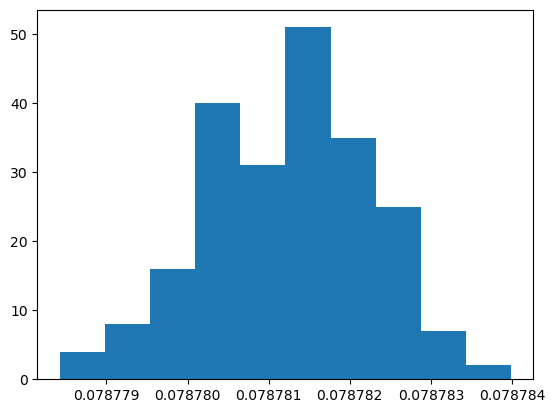

In [369]:
plt.hist(m[0,:])

In [26]:
sns.histplot(data=fit_df, x='alpha_opt', label='alpha opt')
sns.histplot(data=fit_df, x='alpha_pes', label='alpha pes')
sns.histplot(data=fit_df, x='alpha_mix', label='alpha mix')
sns.histplot(data=fit_df, x='beta', label='beta')

plt.xlabel('parameter value')
plt.legend()
plt.show()

ValueError: Could not interpret value `alpha_opt` for parameter `x`

# intergrated BIC

In [26]:
param_names

['alpha_pos', 'alpha_neg', 'beta']

In [27]:
with open('./RW_all/EMfit_RW_basic.pkl', 'rb') as f:
    basic = pickle.load(f)

with open('./RW_all/EMfit_RW_outcome.pkl', 'rb') as f:
    outcome = pickle.load(f)

with open('./RW_all/EMfit_RW_valence.pkl', 'rb') as f:
    valence = pickle.load(f)

with open('./RW_all/EMfit_RW_context.pkl', 'rb') as f:
    context = pickle.load(f)

In [ ]:
# bicint = calc_BICint(all_data, param_names, posterior['mu'], posterior['sigma'], rw_models.fit)

In [28]:
# est 15m 
bicint_basic    = calc_BICint(all_data, ['alpha', 'beta'],                  basic['RW_basic']['fit']['gauss.mu'],     basic['RW_basic']['fit']['gauss.sigma'],     rw_models.fit_slot_basic)
bicint_outcome  = calc_BICint(all_data, ['alpha_rew', 'alpha_pun', 'beta'], outcome['RW_outcome']['fit']['gauss.mu'], outcome['RW_outcome']['fit']['gauss.sigma'], rw_models.fit_slot_outcome)
bicint_valence  = calc_BICint(all_data, ['alpha_pos', 'alpha_neg', 'beta'], valence['RW_valence']['fit']['gauss.mu'], valence['RW_valence']['fit']['gauss.sigma'], rw_models.fit_slot_valence)
bicint_context  = calc_BICint(all_data, ['alpha_opt', 'alpha_pes', 'alpha_mix', 'beta'], context['RW_context']['fit']['gauss.mu'], context['RW_context']['fit']['gauss.sigma'], rw_models.fit_slot_context)

In [ ]:
bicint_context  = calc_BICint(all_data, ['alpha_opt', 'alpha_pes', 'alpha_mix', 'beta'], context['RW_context']['fit']['gauss.mu'], context['RW_context']['fit']['gauss.sigma'], rw_models.fit_slot_context)

In [29]:
bicint_basic, bicint_outcome, bicint_valence, bicint_context

(30448.06687756898, 30185.102654524755, 30183.509431142822, 30164.703706258373)

In [30]:
# save intergrated bic score as pkl
bicint = {'RW_basic': bicint_basic, 'RW_outcome': bicint_outcome, 'RW_valence': bicint_valence, 'RW_context': bicint_context}
with open('bicint_RW.pkl', 'wb') as f:
    pickle.dump(bicint, f)


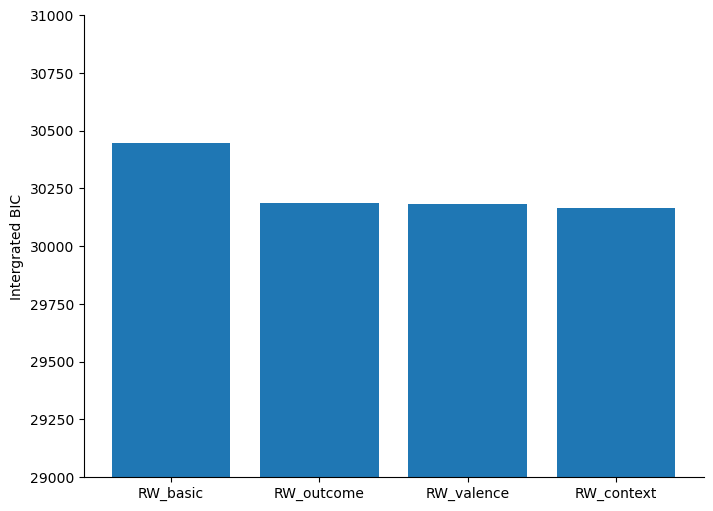

In [31]:
# plot bicint for each model as bar plot
plt.figure(figsize=(8, 6))
plt.bar(['RW_basic', 'RW_outcome', 'RW_valence', 'RW_context'], [bicint_basic, bicint_outcome, bicint_valence, bicint_context])
plt.ylim(29000, 31000)
plt.ylabel('Intergrated BIC')

sns.despine()

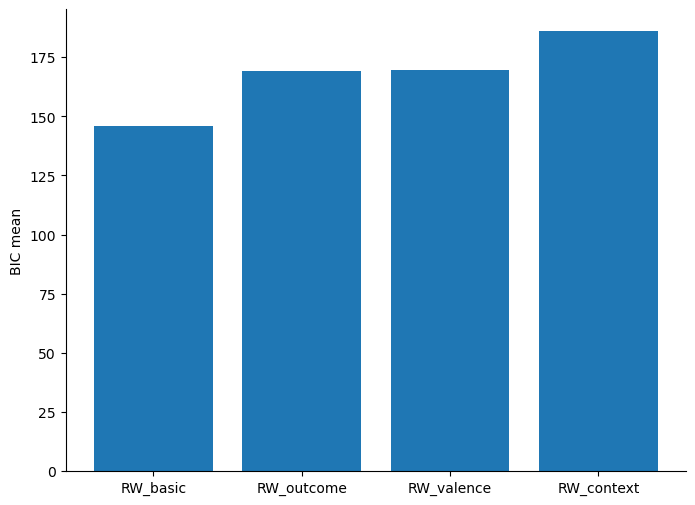

In [33]:
b_sum = basic['RW_basic']['fit']['bic'].mean()
o_sum = outcome['RW_outcome']['fit']['bic'].mean()
v_sum = valence['RW_valence']['fit']['bic'].mean()
c_sum = context['RW_context']['fit']['bic'].mean()

# plot bicint for each model as bar plot
plt.figure(figsize=(8, 6))
plt.bar(['RW_basic', 'RW_outcome', 'RW_valence', 'RW_context'], [b_sum, o_sum, v_sum, c_sum])
plt.ylabel('BIC mean')

sns.despine()

In [ ]:
# plot histogram for each model parameter
sns.histplot(data=slot_PE, x='alpha_pos', kde=True, bins=20, palette='Set2', label='alpha positive')
sns.histplot(data=slot_PE, x='alpha_neg', kde=True, bins=20, palette='Set2', label='alpha negative')
sns.histplot(data=slot_PE, x='beta', kde=True, bins=20, palette='Set2', label='beta')
plt.legend()
sns.despine()
plt.xlabel('parameter value')
plt.title('RW valence model')

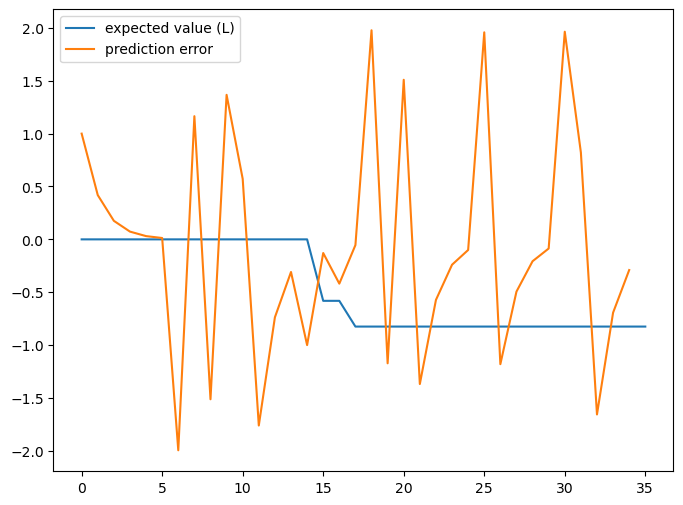

In [295]:
ev = basic['RW_basic']['fit']['ev']
cl = basic['RW_basic']['fit']['choices_L']
pe = basic['RW_basic']['fit']['pe']

# plot ev, cl, pe using index as x-axis
plt.figure(figsize=(8, 6))
plt.plot(ev[0,0,:,0], label='expected value (L)')
plt.plot(pe[0,0,:], label='prediction error')
# plt.plot(cl[0,0,:,0], label='choice Left')
plt.legend()

In [297]:
ev.shape

(219, 3, 36, 2)

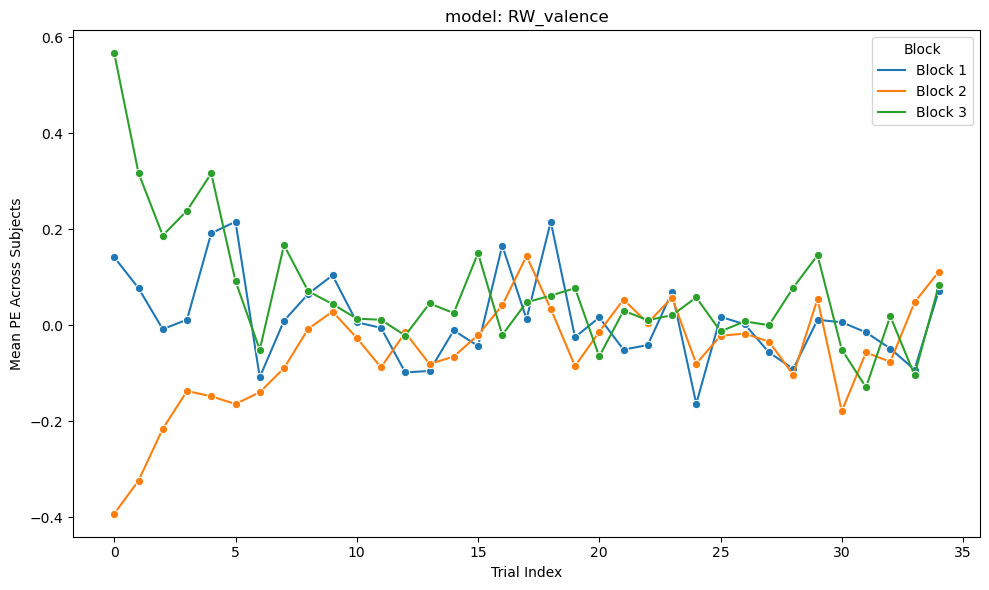

In [305]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example: Array of shape (219, 3, 35)
# Replace this with your actual array
data = valence['RW_valence']['fit']['pe']

# Define the number of subjects, block types, and trials
num_subjects, num_blocks, num_trials = data.shape

# Compute the average value across subjects for each block and trial
mean_data = np.mean(data, axis=0)  # Shape: (3, 35)

# Convert the data into a DataFrame for easier plotting with Seaborn
trial_index = np.tile(np.arange(num_trials), num_blocks)  # Repeat trial index for each block
block_index = np.repeat(np.arange(num_blocks), num_trials)  # Block type for each trial
values = mean_data.flatten()  # Flatten the mean data to match the trial/block structure

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Trial': trial_index,
    'Block': block_index,
    'Value': values
})

# Replace block indices with meaningful labels if needed
df['Block'] = df['Block'].replace({0: 'Block 1', 1: 'Block 2', 2: 'Block 3'})

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Trial', y='Value', hue='Block', marker='o')

# Add labels and title
plt.xlabel('Trial Index')
plt.ylabel('Mean PE Across Subjects')
plt.title('model: RW_valence')

# Show the plot
plt.tight_layout()
plt.show()


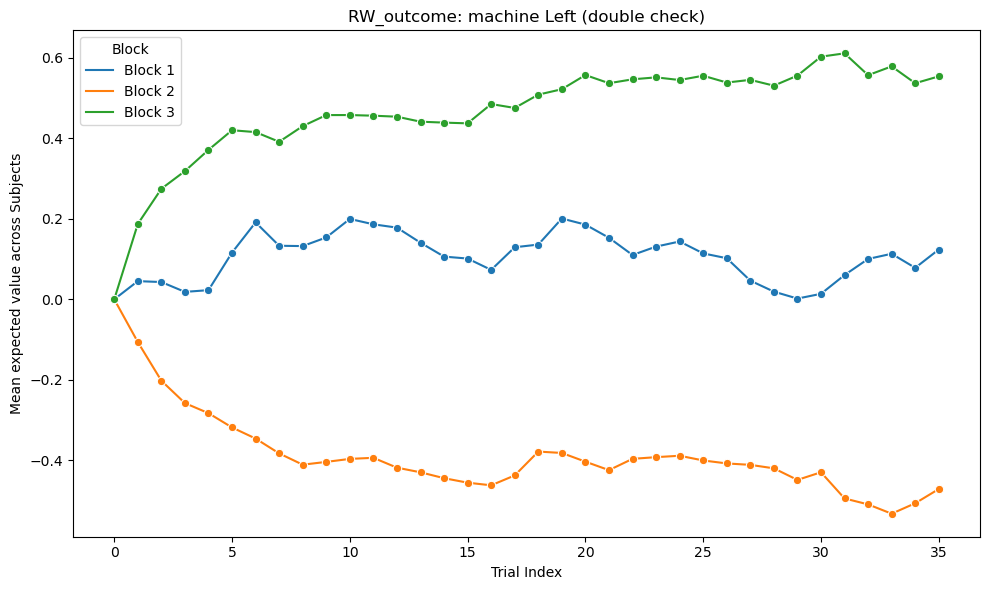

In [312]:
data = outcome['RW_outcome']['fit']['ev']

# Define the number of subjects, block types, trials, and options
num_subjects, num_blocks, num_trials, num_options = data.shape

# Extract the data for option 1 (index 1, because Python indexing starts at 0)
data_option_1 = data[:, :, :, 1]  # Shape will be (219, 3, 36)

# Compute the mean across subjects for each block and trial (shape: 3, 36)
mean_data_option_1 = np.mean(data_option_1, axis=0)

# Convert the data into a DataFrame for easier plotting with Seaborn
trial_index = np.tile(np.arange(num_trials), num_blocks)  # Repeat trial index for each block
block_index = np.repeat(np.arange(num_blocks), num_trials)  # Block type for each trial
values = mean_data_option_1.flatten()  # Flatten the mean data to match the trial/block structure

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Trial': trial_index,
    'Block': block_index,
    'Value': values
})

# Replace block indices with meaningful labels if needed
df['Block'] = df['Block'].replace({0: 'Block 1', 1: 'Block 2', 2: 'Block 3'})

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Trial', y='Value', hue='Block', marker='o')

# Add labels and title
plt.xlabel('Trial Index')
plt.ylabel('Mean expected value across Subjects')
plt.title('RW_outcome: machine Left (double check)')

# Show the plot
plt.tight_layout()
plt.show()


In [306]:
ev.shape

(219, 3, 36, 2)

# Parameter recovery

In [19]:
for param_idx, param_label in enumerate(['beta', 'lr']):
    simulated_param = subj_dict['params'][:,param_idx]
    fitted_params = est_params[:,param_idx]
    plotting.plot_scatter(simulated_param, f'Simulated {param_label}', 
                 fitted_params, f'Estimated {param_label}')

ValueError: All arrays must be of the same length

In [ ]:
## Code if you want to open in MATLAB (leaving here for Shawn to reference so he doesn't have search for it again)

# import scipy.io
# # Save m and h to a .mat file
# data = {'m': m, 'h': inv_h}
# scipy.io.savemat('Mean_Hess_example.mat', data)

# curmu,cursigma,flagcov,covmat_out = compGauss_ms(m,inv_h,2)
# print(curmu,cursigma,flagcov,covmat_out )